<a href="https://colab.research.google.com/github/fpinell/mlsa/blob/main/AA20252026/notebooks/Lecture_5_Seq2Seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Software Analysis (MLSA)

## University of Florence -- IMT School for Advanced Studies Lucca

### Fabio Pinelli
<a href="mailto:fabio.pinelli@imtlucca.it">fabio.pinelli@imtlucca.it</a><br/>
IMT School for Advanced Studies Lucca<br/>
2025/2026<br/>
October, 28 2025

# Outline

- Sequence to sequence
  + Encoder Decoder architecture
  + Teacher forcing
  + Other details
  + Training and test
- Attention Mechanism
  + Encoder - Decoder and attention
  + Details and computation
  + Mask
  + Training and test
- Multihead attention



## So far on Deep Neural Networks
- Fully connected Networks
- Recurrent Neural Networks and their variants
  - GRU
  - LSTM

In [1]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)
except ModuleNotFoundError:
    pass

from config import *
config_chapter9()
# This is needed to render the plots in this chapter
from plots.chapter8 import *
from plots.chapter9 import *

Finished!


/content/plots/chapter8.py:470: SyntaxWarning: invalid escape sequence '\ '
  axs[i][j+1].set_title(titles[j+1][:-1] + '\ [' + ','.join(['{:.2f}'.format(v) for v in gates[layer][i]]) + ']$')


In [2]:
import copy
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset

from data_generation.square_sequences import generate_sequences
from stepbystep.v4 import StepByStep

# Sequence-to-Sequence

Sequence-to-sequence problems are more complex than those we handled so far.
In this settings we have two sequence:
- **Source**
- **Target**

We use the former (*source*) to predict the latter (*target*) and they might have different lengths.

What can be a typical example of Sequence-to-Sequence that you faced quite often in these days?

... Translation.

Source = 'Sentence in English'
Target = 'Sequence of words in another language"

This type of problem can be faced with a **encoder-decoder architecture**

Do you have another example in mind? More related to Computer science?




Let's make the things simpler, for now.

We can reuse our squares we used last time.

## Data Generation

Still the same squares but our source sequence is given by the first two corners
and the target sequence is the next two corners.

Notice that, the **order is important** you don't have to guess just the coordinates correct, but you need to generate them in the correct order, following the same direction.



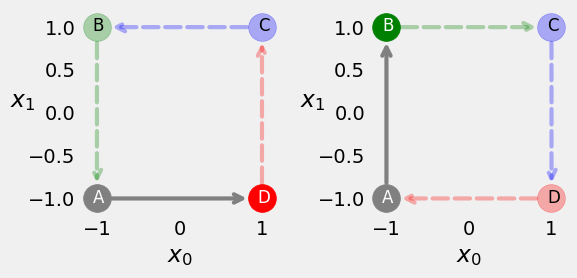

In [3]:
fig = counter_vs_clock(binary=False)

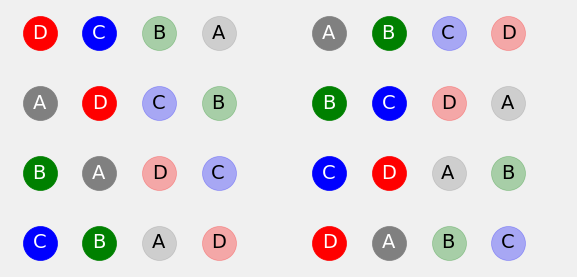

In [4]:
'''
4 Corners to start and 2 directions to follow
This gives us 8 possible sequences
'''


fig = plot_sequences(binary=False, target_len=2)



Since the desired output of our model is a sequence of coordinates $(x_0, x_1)$ we are dealing with a **regression problem**

Therefore, **Mean Squared Error** is the *loss* function to compare the predicted and actual coordinates for the two points in the target sequence.

In [5]:
points, directions = generate_sequences(n=256, seed=13)

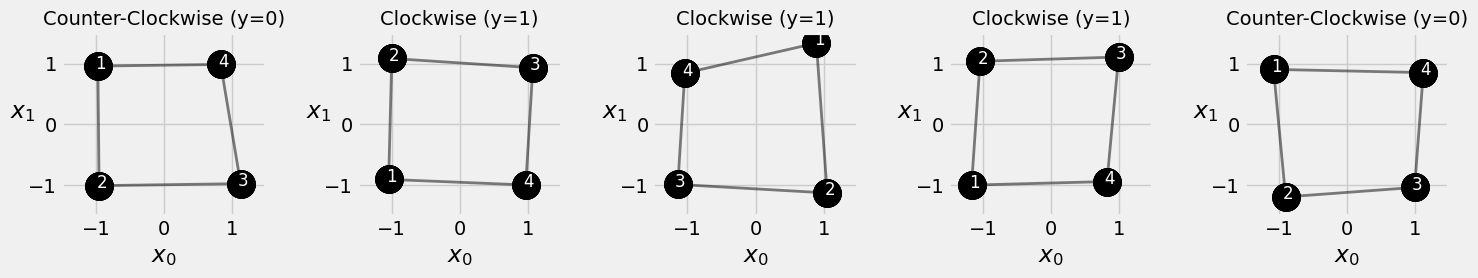

In [6]:
fig = plot_data(points, directions, n_rows=1)

## Encoder-Decoder Architecture

The encoder-decoder architecture is a combination of 2 models:
- The encoder: it generates a *representation* of the *source* sequence, it **encodes** it $⇒$ does this recall something to you???
- The decoder: it generates the target sequence from an initial representation, it decodes it.

**Encode the source sequence**, get its *representation* and feed it to the **decoder** so it generates the **target sequence**.

### Encoder

Creating a representation of a sequence is what the recurrent layers do.
They generate a final hidden state that is a representation of the input sequence!

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder.png?raw=1)

In [7]:
'''
A simplified version of our recurrent networks.

We don't need the classification layer.

We return the full sequence of hidden states even if we need just the final one

We will see later why.
'''

class Encoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)

    def forward(self, X):
        rnn_out, self.hidden = self.basic_rnn(X)

        return rnn_out # N, L, F

An example

In [8]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2] # first two corners
target_seq = full_seq[:, 2:] # last two corners

we encode here the source sequence that is represented by the first two points

In [9]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq) # output is N, L, F
hidden_final = hidden_seq[:, -1:]   # takes last hidden state
hidden_final

tensor([[[ 0.3105, -0.5263]]], grad_fn=<SliceBackward0>)

### Decoder

To decode the final hidden state to a sequence we can use recurrent layers again

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/decoder.png?raw=1)

### Some comments about the Decoder:
- In the first step, the initial hidden state is the encoder's final hidden state $(h_f)$ in blue.
- The first cell will output a new hidden state $(h_2)$. This is both output of that cell and one of the input of the next cell
- Last time the final hidden state was the input for a linear layer to produce the classification (i.e., logits). In this case, we run the output of every cell through a linear layer $(W^Th)$ to convert each hidden state in to predicted coordinates $(x_2)$
- The predicted coordinates are then used as one of the input of the second step
- The first cell takes two inputs: an initial hidden state and a first data point
- The first data point is actually the last data point of the source sequence, since the target sequence is a continuation of the source sequence.

In [10]:
class Decoder(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
        self.regression = nn.Linear(self.hidden_dim, self.n_features)

    def init_hidden(self, hidden_seq):
        # We only need the final hidden state
        hidden_final = hidden_seq[:, -1:] # N, 1, H
        # But we need to make it sequence-first
        self.hidden = hidden_final.permute(1, 0, 2) # 1, N, H

    def forward(self, X):
        # X is N, 1, F
        batch_first_output, self.hidden = self.basic_rnn(X, self.hidden)

        last_output = batch_first_output[:, -1:]
        out = self.regression(last_output)

        # N, 1, F
        return out.view(-1, 1, self.n_features)

1. We initialize the decoder's hidden state using encoder's final hidden state
  - the hidden state must always be **sequence first**, and the encoder's output is batch-first, then we need to permute the first two dimension.
2. The recurret layer both uses and updates the hidden state (that is an attribute of the class
  - the hidden state is both input and output of the recurrent layer

    ```batch_first_output, self.hidden = self.basic_rnn(X, self.hidden)```
3. The output has the same shape of the input (N,1,F)
4. The forward method will be called several times as we loop over the generation of the target sequence

In [11]:
hidden_seq

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [12]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)

# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs)   # Predicts coordinates
    print(f'Output: {out}\n')
    # Predicted coordinates are next step's inputs
    inputs = out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward0>)



We created a loop to generate sequences of length 2 using the predictions of one step as input to the next.
The hidden state is entirely handled by the model itself.

With the previous approach, we can notice that an untrained model makes very bad predictions and these predictions are used as inputs for the subsequent steps.

This makes the model training really hard since we might have a propagation of the errors.

... We can try to use the actual target sequence, this is called **teacher forcing**

#### Teacher Forcing

Ignore the predictions and use the real data from the target.
We can adapt the code easily, changing the last line of the previous ```for```

In [13]:
# Initial hidden state will be encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs) # Predicts coordinates
    print(f'Output: {out}\n')
    # But completely ignores the predictions and uses real data instead
    inputs = target_seq[:, i:i+1]

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[0.2265, 0.4529]]], grad_fn=<ViewBackward0>)



Now, the bad predictions are caused by poor performance of the model and they do not depend by any bad predictions of previous steps.

Do you see any problem here???


$⇒$ This works at training time, where we know the target, but what about testing time, where the target sequence is *unknown*.


The model trained with **teacher forcing** will minimize the loss given the correct inputs at every step of the target sequence, but this will never happen at testing time, therefore, the model is likely to perform poorly when needs to use its own predictions as inputs.


What can we do???

In [14]:
# Initial hidden state is encoder's final hidden state
decoder.init_hidden(hidden_seq)
# Initial data point is the last element of source sequence
inputs = source_seq[:, -1:]

teacher_forcing_prob = 0.5
target_len = 2
for i in range(target_len):
    print(f'Hidden: {decoder.hidden}')
    out = decoder(inputs)
    print(f'Output: {out}\n')
    # If it is teacher forcing
    if torch.rand(1) <= teacher_forcing_prob:
        # Takes the actual element
        inputs = target_seq[:, i:i+1]
    else:
        # Otherwise uses the last predicted output
        inputs = out

Hidden: tensor([[[ 0.3105, -0.5263]]], grad_fn=<PermuteBackward0>)
Output: tensor([[[-0.2339,  0.4702]]], grad_fn=<ViewBackward0>)

Hidden: tensor([[[ 0.3913, -0.6853]]], grad_fn=<StackBackward0>)
Output: tensor([[[-0.0226,  0.4628]]], grad_fn=<ViewBackward0>)



During training, sometimes the model uses the teacher forcing and sometime its own predictions.

- We help the model by providing an actual input
- We force to be robust enough to generate and use its own predictions.

```if torch.rand(1) <= teacher_forcing_prob:```

### Encoder + Decoder

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder_decoder.png?raw=1)

- The Encoder receives the source sequence ($x_0$ and $x_1$) and generates the representation of the source sequence, its final hidden state $h_f$
- The decoder receives the hidden state from the encoder, together with the last known element of the sequence ($x_1$). It outputs a hidden state $h_2$ that is converted into the first set of predicted coordinates ($x_2$) using a linear layer.
- In the next iteration, the model randomly uses the predicted $x_2$ or the actual $x_2$ set of coordinates, and $h_2$. It outputs the second predicted coordinates ($x_3$).
- The final output of the encoder+decoder model is the full sequence of predicted coordinates $[x_2, x_3]$

In [15]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.teacher_forcing_prob = teacher_forcing_prob
        self.outputs = None

    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        # N, L (target), F
        self.outputs = torch.zeros(batch_size,
                              self.target_len,
                              self.encoder.n_features).to(device)

    def store_output(self, i, out):
        # Stores the output
        self.outputs[:, i:i+1, :] = out

    def forward(self, X):
        # splits the data in source and target sequences
        # the target seq will be empty in testing mode
        # N, L, F
        source_seq = X[:, :self.input_len, :]
        target_seq = X[:, self.input_len:, :]
        self.init_outputs(X.shape[0])

        # Encoder expected N, L, F
        hidden_seq = self.encoder(source_seq)
        # Output is N, L, H
        self.decoder.init_hidden(hidden_seq)

        # The last input of the encoder is also
        # the first input of the decoder
        dec_inputs = source_seq[:, -1:, :]

        # Generates as many outputs as the target length
        for i in range(self.target_len):
            # Output of decoder is N, 1, F
            out = self.decoder(dec_inputs)
            self.store_output(i, out)

            prob = self.teacher_forcing_prob
            # In evaluation/test the target sequence is
            # unknown, so we cannot use teacher forcing
            if not self.training:
                prob = 0

            # If it is teacher forcing
            if torch.rand(1) <= prob:
                # Takes the actual element
                dec_inputs = target_seq[:, i:i+1, :]
            else:
                # Otherwise uses the last predicted output
                dec_inputs = out

        return self.outputs

The forward method splits the input into source
and target.
It loops to generate the target sequence and implements the teacher forcing in training

We add the ```init_outputs``` and ```store_output``` to create a tensor for storing the resulting target sequence and to store the output produced.

In [16]:
encdec = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=1.0)

In training mode, the model expects the full sequence and it uses randomly the teacher forcing technique.

In [17]:
encdec.train()
encdec(full_seq)

tensor([[[-0.2339,  0.4702],
         [ 0.2265,  0.4529]]], grad_fn=<CopySlices>)

In test, it only needs the source

In [18]:
encdec.eval()
encdec(source_seq)

tensor([[[-0.2339,  0.4702],
         [-0.0226,  0.4628]]], grad_fn=<CopySlices>)

### Data Preparation

In [19]:
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]

/tmp/ipython-input-1483810553.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  full_train = torch.as_tensor(points).float()


In [20]:
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]

In [21]:
train_data = TensorDataset(full_train, target_train)
test_data = TensorDataset(source_test, target_test)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)
test_loader = DataLoader(test_data, batch_size=16)

### Model Training & Configuration

In [22]:
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder = Decoder(n_features=2, hidden_dim=2)
model = EncoderDecoder(encoder, decoder, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [23]:
sbs_seq = StepByStep(model, loss, optimizer)
sbs_seq.set_loaders(train_loader, test_loader)
sbs_seq.train(100)

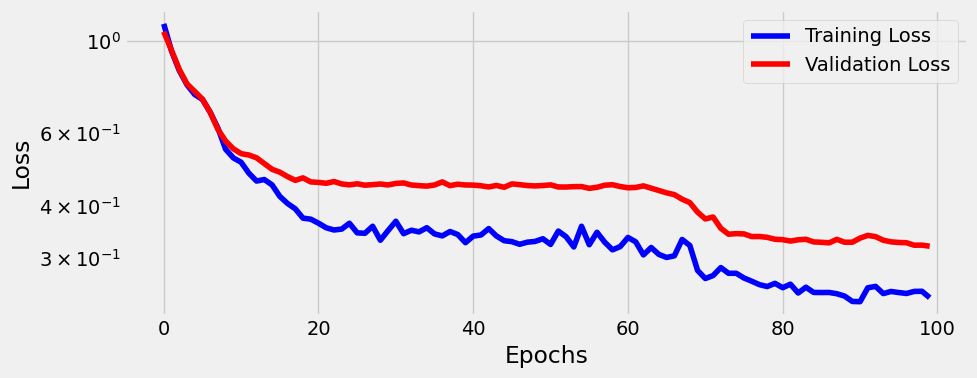

In [24]:
fig = sbs_seq.plot_losses()

### Visualizing Predictions

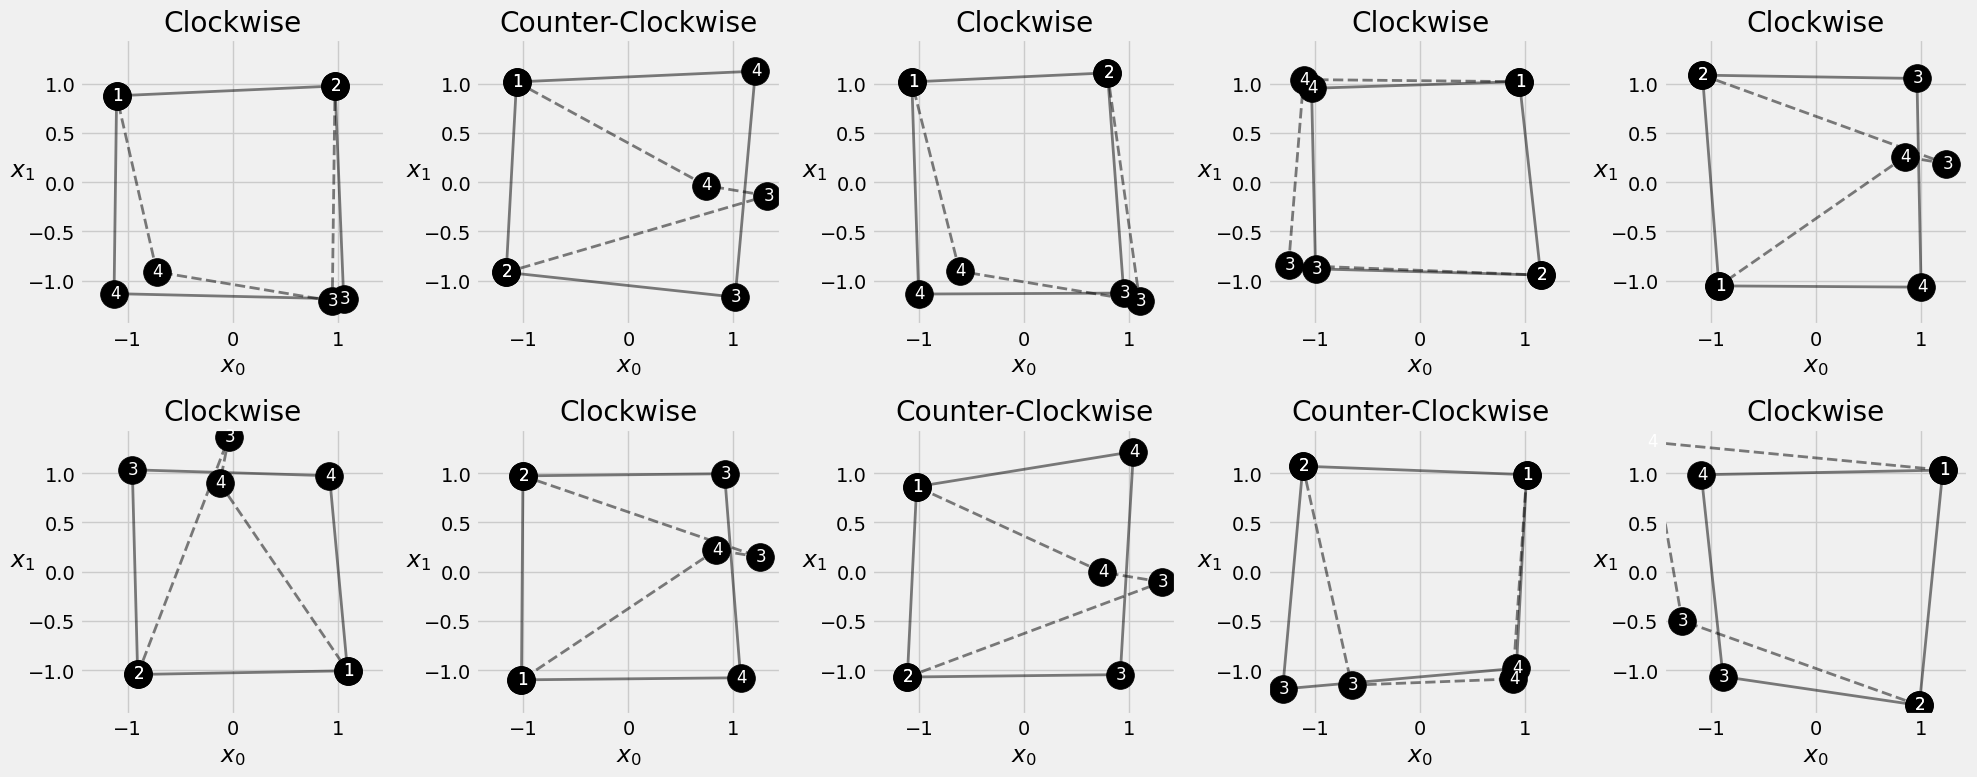

In [25]:
fig = sequence_pred(sbs_seq, full_test, test_directions)

Some of them look quite good (half) but in other cases the predicted coordinates are overalapping with each other and close to midpoints between tha actual coordinates.

### Can we do better?

The whole source sequence is represented by a single hidden state.
The amount of information, also in our simple example, is quite small, so... what do you think we can do?

## Attention

Do you remember in our first code that the encoder outputs the full list of hidden state...

We could give the power to the decoder to choose one or more encoder's hidden state instead of using just one.

This will give more **flexibility** to use the hidden state that's more useful at a given step of the target-sequence generation.

We move to the translation problem for a bit:

We have the English sentence: "The european economic zone"
We want to translate it in... French, that could be: "La zone économique européenne".

The translation of *the* is *la*, how is it possible to translate *the* in *la* without any further information?
The **model** needs to find the noun to which the article *the* refers to.
In this case, is *zone* and this is the last word of the English sentence.


Let's try to imagine what this means in hidden state.

The source sequence is the English sentence, the French one is our target.
Assuming that we can map each word to a numeric vector, we can use an encoder to encode the English words, each word corrosponds to a hidden state.

Considering the role played by the decoder is to generate the translated words, if it can choose which hidden states from the encoder it will use to generate the output, it means that it can choose which English words it will use to generate each translated word.

In our example, we can assume that the decoder would choose the *first* and the *last* encoded hidden states. They correspond to the word *the* and *zone*.

In other words, we can say that the decoder is paying attetion to different elements of the source sequence...

$⇒$ **The Attention Mechanism**


When it needs to translate *zone* it only needs to pay attention to the last English word.

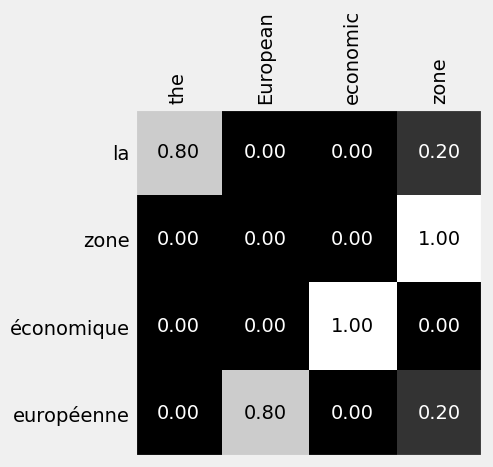

In [26]:
fig = figure9()

**These are made up numbers!!!!!**


We suppose how much attention the decoder is paying to each English word in order to generate the target sequence


### Alphas or Attention Score

These weights are called **Attention scores** (or alphas)

- They add up to one
- Compute a weighted average of the encoder's hidden states.



![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/enc_dec_attn_translate.png?raw=1)

The decoder recruits the **Attention Mechanism** to decide which parts of the source sequence it must pay attention to.

In our example, the attention mechanism informs the decoder that it should pay 80%of its attention to the encoder's hidden state corresponding to the word *the* and 20% to the hidden state related to *zone*.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/context_translate.png?raw=1)

### "Values"

- Values (V): encoder hidden states (or their affine transformations)
- The resulting multiplication of a "value" by its corresponding attention score is called **allignment vector**
- The sum of all allignment vectors (the weighted average of the hidden states) is called **context vector**

$$
\large
\text{context vector} = \underbrace{\alpha_0 * h_0}_{\text{alignment vector}_0} + \underbrace{\alpha_1 * h_1}_{\text{alignment vector}_1} = 0.8 * \text{value}_{the} + 0.2 *\text{value}_{zone}
$$

But how can we estimate the attention scores???

The attention scores are based on matching each hidden state of the decoder ($h_2$) to every hidden state of the encoder ($h_0$ and $h_1$). Some of them will be good matches (high attention scores), others can be poor matches (low attention scores).

### "Keys" and "Queries"

- **Keys (K)**: Encoder hidden states
- **Queries (Q)**: Decoder hidden states

The encoder hidden states are both Values and Keys, but we will apply two affine transformation, one for the keys and one for the values.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/kq_matches.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/score_alignment_translate.png?raw=1)

The query is "matched" to both Keys to compute the attention scores used to compute the context vector, which is simply the weighted sum of the values.

Let's go back to our lovely and simple squares and see how the diagram can be represented in code

### Computing the Context Vector

In [ ]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [ ]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
hidden_seq = encoder(source_seq)

values = hidden_seq # N, L, H
values

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [ ]:
keys = hidden_seq # N, L, H
keys

tensor([[[ 0.0832, -0.0356],
         [ 0.3105, -0.5263]]], grad_fn=<TransposeBackward1>)

In [ ]:
torch.manual_seed(21)
decoder = Decoder(n_features=2, hidden_dim=2)
decoder.init_hidden(hidden_seq)

inputs = source_seq[:, -1:]
out = decoder(inputs)

In [ ]:
'''
The first query is the decoder hidden state, that is sequence first, and we need
to permute it, making it batch_first
'''


query = decoder.hidden.permute(1, 0, 2)  # N, 1, H
query

tensor([[[ 0.3913, -0.6853]]], grad_fn=<PermuteBackward0>)

Now we have the Q, K and V, we can compute the alphas

In [ ]:
def calc_alphas(ks, q):
    N, L, H = ks.size()
    alphas = torch.ones(N, 1, L).float() * 1/L
    return alphas

alphas = calc_alphas(keys, query)
alphas

tensor([[[0.5000, 0.5000]]])

Alphas need to be in the right shape so that when multiplied by the values in (N,L,H) it will result a weighted sum of the allignment vectors with shape (N,1,H).

We can use the ```torch.bmm()``` to perform a batch matrix multiplication, ignoring the first dimension


$$
\Large
(\color{green}{N}\color{black}, 1, \color{red}{L}\color{black}) \times
(\color{green}{N}\color{black}, \color{red}{L}\color{black}, H) =
(\color{green}{N}\color{black}, 1\color{black}, H)
$$

In [ ]:
# N, 1, L x N, L, H -> 1, L x L, H -> 1, H
context_vector = torch.bmm(alphas, values)
context_vector

tensor([[[ 0.1968, -0.2809]]], grad_fn=<BmmBackward0>)

In [ ]:
'''
Once we have the context vector, we can concatenate it with the query

And use it as input of the final linear layer to actually generates the coordinates.
'''
concatenated = torch.cat([context_vector, query], axis=-1)
concatenated

tensor([[[ 0.1968, -0.2809,  0.3913, -0.6853]]], grad_fn=<CatBackward0>)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encdec_attn.png?raw=1)

### Scoring Method

Let's see how we can transform good match between a query and a key to an attention score.

- K and Q are vectors of the same number of dimensions, the hidden dimensions of our recurrent network.
- To understand if two vectors are a good match can be seen as if two vectors are similar.

- Therefore we can use the cosine similarity that is 1 if two vectors point in the same direction, 0 if they are hortogonal, -1 if they point in opposite directions.

$$
\Large
\text{cos}\ \theta = \frac{\sum_i{q_ik_i}}{\sqrt{\sum_j{q_j^2}}\sqrt{\sum_j{k_j^2}}}
$$

$$
\Large
\text{cos}\ \theta \sqrt{\sum_j{q_j^2}}\sqrt{\sum_j{k_j^2}}= \sum_i{q_ik_i}
$$

$$
\Large
\text{cos}\ \theta\ ||Q||\ ||K|| = Q \cdot K
$$

Thus, the dot product is indeed the cosine similarity scaled by the product of the magnitudes of the two vectors. This scaling by the norms is what makes the dot product sensitive to both direction and magnitude, while cosine similarity focuses only on the angle (direction) between the vectors.

In [ ]:
# N, 1, H x N, H, L -> N, 1, L
products = torch.bmm(query, keys.permute(0, 2, 1))
products

tensor([[[0.0569, 0.4821]]], grad_fn=<BmmBackward0>)

### Attention Scores

In [ ]:
'''
They need to sum up to one
'''

alphas = F.softmax(products, dim=-1)
alphas

tensor([[[0.3953, 0.6047]]], grad_fn=<SoftmaxBackward0>)

The first hidden state contributes to roughly the 40% while the second to the remaining 60%.

We can add the dot product on the ```calc_alphas```

In [ ]:
def calc_alphas(ks, q):
    # N, 1, H x N, H, L -> N, 1, L
    products = torch.bmm(q, ks.permute(0, 2, 1))
    alphas = F.softmax(products, dim=-1)
    return alphas

### Visualizing the Context Vector

In [ ]:
q = torch.tensor([.55, .95]).view(1, 1, 2) # N, 1, H
k = torch.tensor([[.65, .2],
                  [.85, -.4],
                  [-.95, -.75]]).view(1, 3, 2) # N, L, H

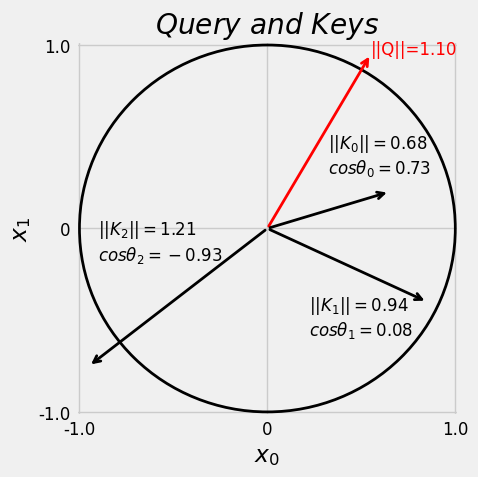

In [ ]:
fig = query_and_keys(q.squeeze(), k.view(3, 2))

$$
\Large
\begin{array}
&Q \cdot K_0 = cos \theta_0\ ||Q||\ ||K_0|| =& &0.73 &*& 1.10 &*& 0.68 =& &0.54
\\
Q \cdot K_1 = cos \theta_1\ ||Q||\ ||K_1|| =& &0.08 &*& 1.10 &*& 0.94 =& &0.08
\\
Q \cdot K_2 = cos \theta_2\ ||Q||\ ||K_2|| =& -&0.93 &*& 1.10 &*& 1.21 =& -&1.23
\end{array}
$$

In [ ]:
# N, 1, H x N, H, L -> N, 1, L
prod = torch.bmm(q, k.permute(0, 2, 1))
prod

tensor([[[ 0.5475,  0.0875, -1.2350]]])

In [ ]:
scores = F.softmax(prod, dim=-1)
scores

tensor([[[0.5557, 0.3508, 0.0935]]])

$$
\Large
\text{context vector}=
0.5557*
\begin{bmatrix}
0.65
\\
0.20
\end{bmatrix}
+
0.3508*
\begin{bmatrix}
\ \ 0.85
\\
-0.40
\end{bmatrix}
+
0.0935*
\begin{bmatrix}
-0.95
\\
-0.75
\end{bmatrix}
$$

In [ ]:
v = k
context = torch.bmm(scores, v)
context

tensor([[[ 0.5706, -0.0993]]])

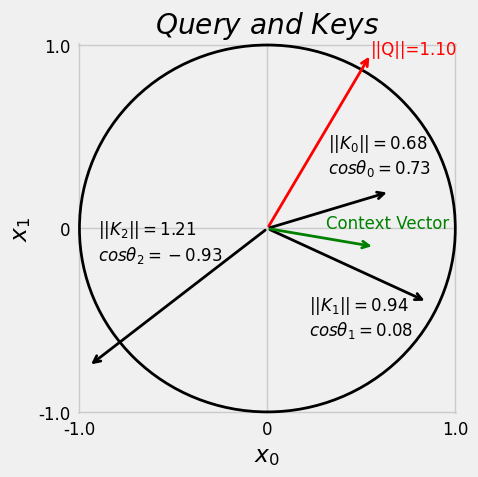

In [ ]:
fig = query_and_keys(q.squeeze(), k.view(3, 2), context)

### Scaled Dot Product

When we deal with a number of hidden dimension much higher than 2, we need to consider that the variance of the elements get larger too.
We can standardize it by scaling the dot product by the inverse of its standard deviation.

$$
\Large
\text{scaled dot product} = \frac{Q \cdot K}{\sqrt{d_k}}
$$

In [ ]:
dims = query.size(-1)
scaled_products = products / np.sqrt(dims)
scaled_products

tensor([[[0.0403, 0.3409]]], grad_fn=<DivBackward0>)

In [ ]:
dummy_product = torch.tensor([4.0, 1.0])
F.softmax(dummy_product, dim=-1), F.softmax(100*dummy_product, dim=-1)

(tensor([0.9526, 0.0474]), tensor([1., 0.]))

In [ ]:
alphas = F.softmax(scaled_products, dim=-1)
alphas

tensor([[[0.4254, 0.5746]]], grad_fn=<SoftmaxBackward0>)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/aiayn_dot.png?raw=1)

In [ ]:
def calc_alphas(ks, q):
    dims = q.size(-1)
    # N, 1, H x N, H, L -> N, 1, L
    products = torch.bmm(q, ks.permute(0, 2, 1))
    scaled_products = products / np.sqrt(dims)
    alphas = F.softmax(scaled_products, dim=-1)
    return alphas

In [ ]:
alphas = calc_alphas(keys, query)
# N, 1, L x N, L, H -> 1, L x L, H -> 1, H
context_vector = torch.bmm(alphas, values)
context_vector

tensor([[[ 0.2138, -0.3175]]], grad_fn=<BmmBackward0>)

### Attention Mechanism

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/attention.png?raw=1)

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        # Affine transformations for Q, K, and V
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None

    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys

    def score_function(self, query):
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores

    def forward(self, query, mask=None):
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()

        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

- Constructor
 + Three linear layer corresponding to the affine transformation for K,V,Q (V we will see later)
 + one attribute for the number of hidden dimensions
 + a placeholder for the attention scores
- init_keys()
  + it receives a batch first sequence of hidden states from the encoder
  + This will be received once and used over and over again with every new query
  + We initialize keys and values once
- score function computes the scaled dot product with an affine transformation of the query
- the forward takes batch first hidden state query the performs 3 steps of the attention mechanism:
 + computes the alignment scores using K and Q
 + computes the attention scores
 + use the V and attention scores to compute the context vector

Mask is left for later.

### Source Mask

the mask can be used to mask some of the values to force the attention mechanism to ignore them.

For instance if you have your sequence with some padded values, you would like to ignore them

In [ ]:
source_seq = torch.tensor([[[-1., 1.], [0., 0.]]])
# pretend there's an encoder here...
keys = torch.tensor([[[-.38, .44], [.85, -.05]]])
query = torch.tensor([[[-1., 1.]]])

the source mask should be False for every padded data point.
With a shape (N,1,L) where L is the length of the source sequence.

In [ ]:
source_mask = (source_seq != 0).all(axis=2).unsqueeze(1)
source_mask # N, 1, L

tensor([[[ True, False]]])

This mask will make the attention score to zero for the padded data points.

In [ ]:
torch.manual_seed(11)
attnh = Attention(2)
attnh.init_keys(keys)

context = attnh(query, mask=source_mask)
attnh.alphas

tensor([[[1., 0.]]])

### Decoder

Let's see how the decoder should be changed to leverage the attention mechanism

- set the attention module and adjust the dimensions for the regression layer
- set the keys and values
- feed the query to the attention and concatenate it to the context vector

In [ ]:
class DecoderAttn(nn.Module):
    def __init__(self, n_features, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_features = n_features
        self.hidden = None
        self.basic_rnn = nn.GRU(self.n_features, self.hidden_dim, batch_first=True)
        self.attn = Attention(self.hidden_dim)
        self.regression = nn.Linear(2 * self.hidden_dim, self.n_features)

    def init_hidden(self, hidden_seq):
        # the output of the encoder is N, L, H
        # and init_keys expects batch-first as well
        self.attn.init_keys(hidden_seq)
        hidden_final = hidden_seq[:, -1:]
        self.hidden = hidden_final.permute(1, 0, 2)   # L, N, H

    def forward(self, X, mask=None):
        # X is N, 1, F
        batch_first_output, self.hidden = self.basic_rnn(X, self.hidden)

        query = batch_first_output[:, -1:]
        # Attention
        context = self.attn(query, mask=mask)
        concatenated = torch.cat([context, query], axis=-1)
        out = self.regression(concatenated)

        # N, 1, F
        return out.view(-1, 1, self.n_features)

In [ ]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [ ]:
torch.manual_seed(21)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)

# Generates hidden states (keys and values)
hidden_seq = encoder(source_seq)
decoder_attn.init_hidden(hidden_seq)

# Target sequence generation
inputs = source_seq[:, -1:]
target_len = 2
for i in range(target_len):
    out = decoder_attn(inputs)
    print(f'Output: {out}')
    inputs = out

Output: tensor([[[-0.3555, -0.1220]]], grad_fn=<ViewBackward0>)
Output: tensor([[[-0.2641, -0.2521]]], grad_fn=<ViewBackward0>)


### Encoder + Decoder + Attention

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encdec_attn.png?raw=1)

1. The data points of the source sequence feed the encoder and generate keys and values
2. each input of the decoder generates one query at a time to produce a context vector
3. Finally, the concatenation between context vector and the current hidden state of the decoder is transformed to predict the coordinates by the output layer

In [ ]:
encdec = EncoderDecoder(encoder, decoder_attn, input_len=2, target_len=2, teacher_forcing_prob=0.0)
encdec(full_seq)

tensor([[[-0.3555, -0.1220],
         [-0.2641, -0.2521]]], grad_fn=<CopySlices>)

In [ ]:
class EncoderDecoderAttn(EncoderDecoder):
    def __init__(self, encoder, decoder, input_len, target_len, teacher_forcing_prob=0.5):
        super().__init__(encoder, decoder, input_len, target_len, teacher_forcing_prob)
        self.alphas = None

    def init_outputs(self, batch_size):
        device = next(self.parameters()).device
        # N, L (target), F
        self.outputs = torch.zeros(batch_size,
                              self.target_len,
                              self.encoder.n_features).to(device)
        # N, L (target), L (source)
        self.alphas = torch.zeros(batch_size,
                                  self.target_len,
                                  self.input_len).to(device)

    def store_output(self, i, out):
        # Stores the output
        self.outputs[:, i:i+1, :] = out
        self.alphas[:, i:i+1, :] = self.decoder.attn.alphas

### Model Configuration & Training

In [ ]:
torch.manual_seed(23)
encoder = Encoder(n_features=2, hidden_dim=2)
decoder_attn = DecoderAttn(n_features=2, hidden_dim=2)
model = EncoderDecoderAttn(encoder, decoder_attn, input_len=2, target_len=2, teacher_forcing_prob=0.5)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
sbs_seq_attn = StepByStep(model, loss, optimizer)
sbs_seq_attn.set_loaders(train_loader, test_loader)
sbs_seq_attn.train(100)

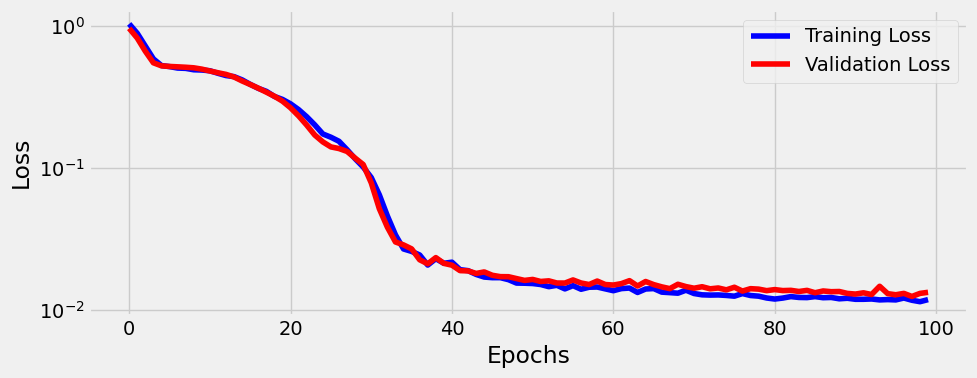

In [ ]:
fig = sbs_seq_attn.plot_losses()

### Visualizing Predictions

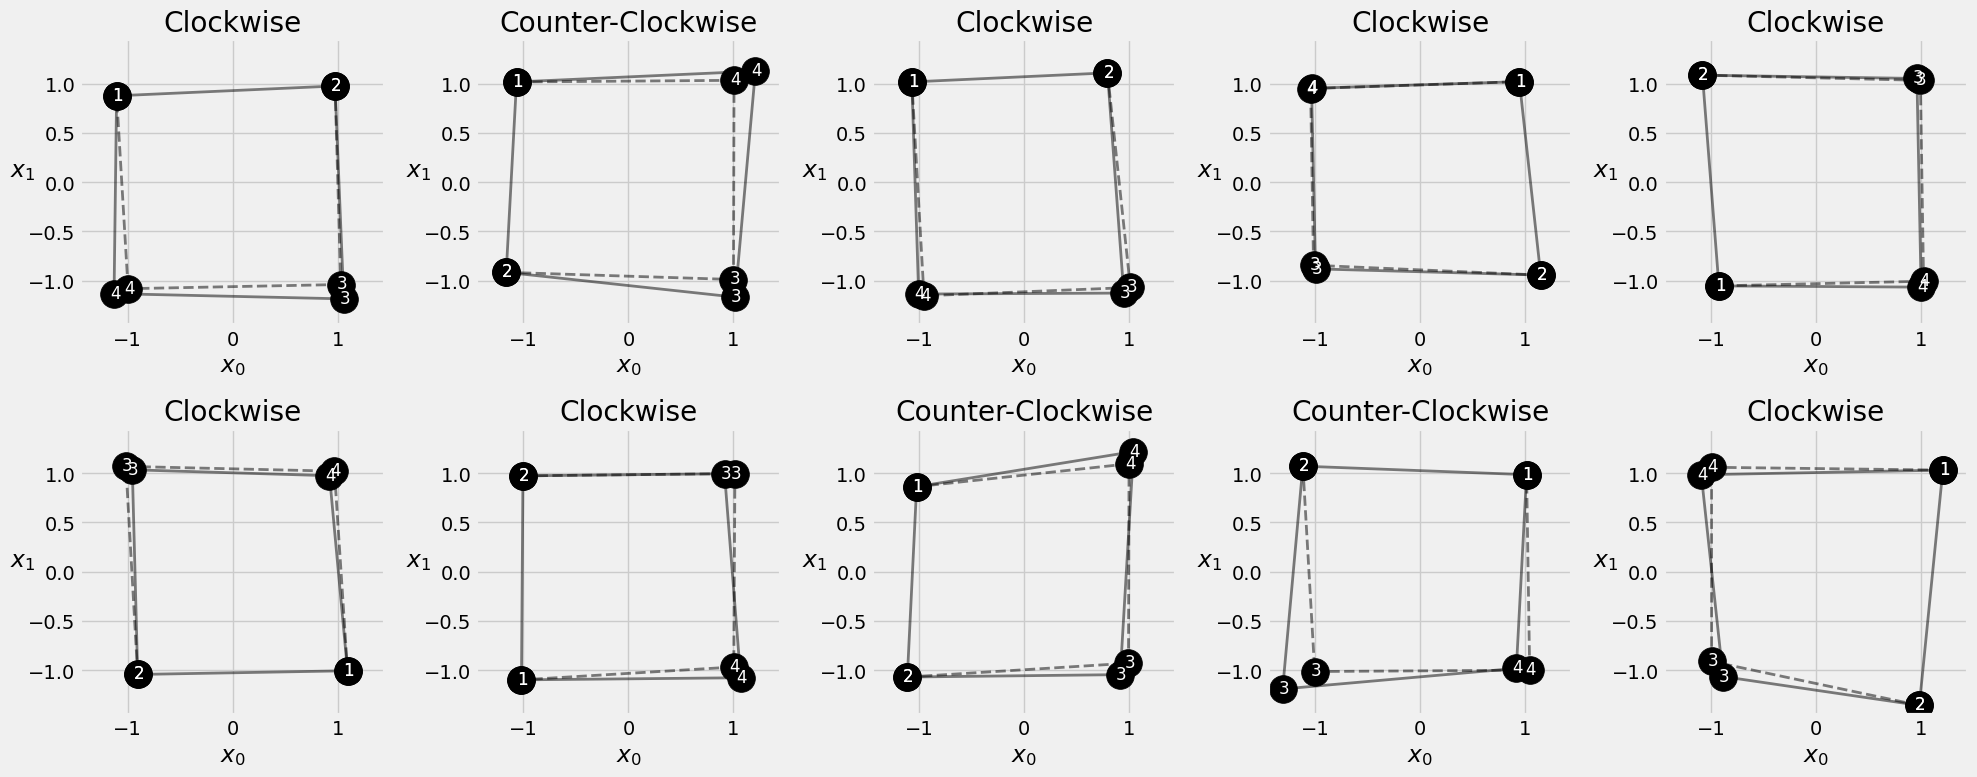

In [ ]:
fig = sequence_pred(sbs_seq_attn, full_test, test_directions)

### Visualizing Attention

In [ ]:
full_train[1:2,:2]

tensor([[[-1.0442, -0.9045],
         [-0.9980,  1.0863]]])

In [ ]:
inputs = full_train[3:4, :2]
# inputs = full_train[1:2,:2]
out = sbs_seq_attn.predict(inputs)
sbs_seq_attn.model.alphas

tensor([[[0.9649, 0.0351],
         [0.0757, 0.9243]]])

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{green}{x_2} & \alpha_{\color{green}{2}\color{red}0} & \alpha_{{\color{green}{2}\color{red}1}} \\
 \color{green}{x_3} & \alpha_{\color{green}{3}\color{red}0} & \alpha_{{\color{green}{3}\color{red}1}}
\end{array}
\implies
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_0} & \color{red}{x_1} \\
\hline
 \color{green}{x_2} & 0.9894 & 0.0106\\
 \color{green}{x_3} & 0.9577 & 0.0423
\end{array}
$$

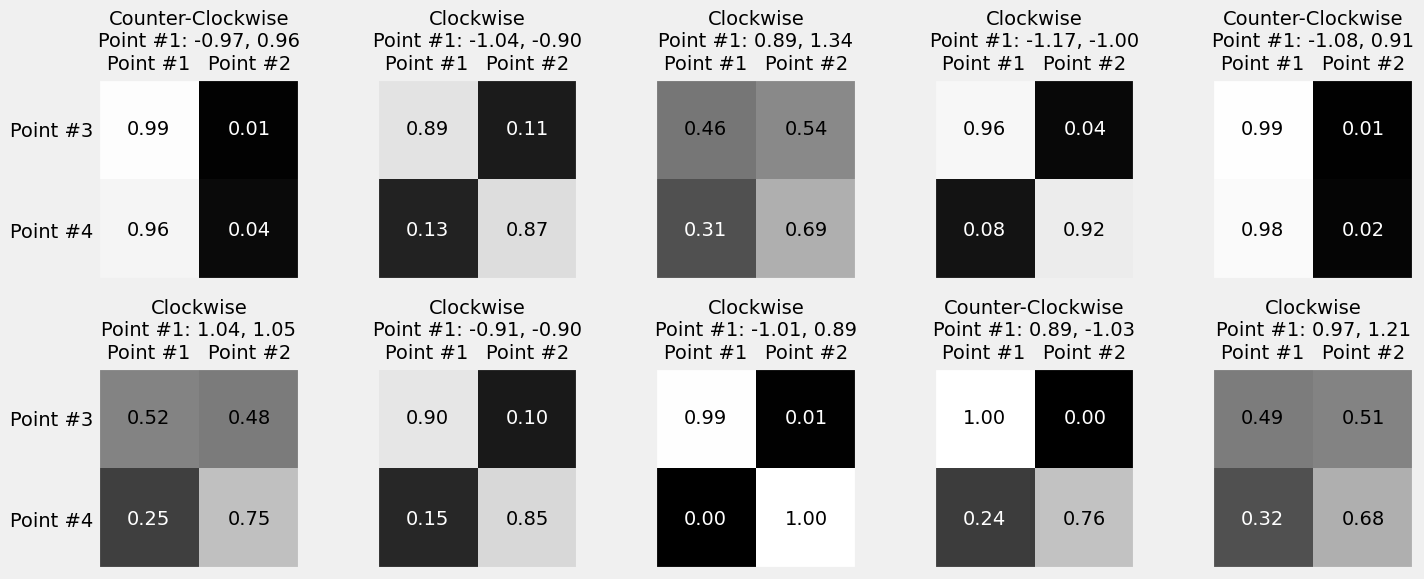

In [ ]:
inputs = full_train[:10, :2]
source_labels = ['Point #1', 'Point #2']
target_labels = ['Point #3', 'Point #4']
point_labels = [f'{"Counter-" if not directions[i] else ""}Clockwise\nPoint #1: {inp[0, 0]:.2f}, {inp[0, 1]:.2f}' for i, inp in enumerate(inputs)]
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels)

### Multi-Headed Attention

Do you know what is better than one attention mechanism?

We can use several attention mechanisms, referred as attention heads

Each attention head produces its own context vector, that will be all concatenated and combined using a linear layer.

The multihead attention mechanism still outputs a single context vector.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/multiattn.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/aiayn_multihead.png?raw=1)

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        self.attn_heads = nn.ModuleList([Attention(d_model,
                                                   input_dim=input_dim,
                                                   proj_values=proj_values)
                                         for _ in range(n_heads)])

    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)

    @property
    def alphas(self):
        # Shape: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)

    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        # Linear transf. to go back to original dimension
        out = self.linear_out(concatenated) # N, 1, D
        return out

    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out

## Self-Attention

Last lesson archictures for sequence-to-sequence problem have RNN layer on both Encoder and Decoder.

What happen if we replace these layers with another **attention mechanism**?

This is the main proposition of the famous paper:
*Attention Is All You Need", Vaswani et Al.

The paper proposes the so called **self-attention mechanism**.

Let's see what this means...


In our previous architectures, the **encoder** receives the source sequence and, one by one, generates **hidden states**. We can replace this process with another attention mechanism (and we will do also for the decoder).

Therefore, keys, values, queries are internal to either an encoder or a decoder. This is way it is called **self-attention**.

So far, keys and values come from the *encoder* but the query comes from the **decoder**. This method is called **cross-attention**.

Notice also that the affine transformations (i.e., linear layers) that we apply to K,V,Q can be used to change the dimensionality from the number of input dimensions to the number of hidden dimensions. This transformation was performed by the **recurrent layers** with the size of the hidden states.  



### Encoder with self-attention

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder_self.png?raw=1)

1. - The source sequence works as Keys, Values and QuerieS
  - Each data point of the source sequence is a query now, thus it produces its own context vector. In particular, it uses the allignment vectors of every data point, including itself.

  - $⇒$ It is possible for a data point to generate a context vector that is only paying attention to itself.

2. Each context vector goes through a Feed Forward network to generate a "hidden state"



Let's see how to generate the hidden state ($h_{00},h_{01}$) of the first data point $(x_{00},x_{01})$

1. The transformed coordinates are used as query (Q).
2. This query is paired -- indipendently -- with each of the two keys, one of them being a different transformation of the same coordinate $(x_{00},x_{01})$, the other being a transformation of the second data point $(x_{10},x_{11})$.
3. These will result in two **attention scores** $(s_0,s_1)$, multiplied by the corresponding values, added up to become the context vector
4. The context vector goes through a feed forwar network and it becomes the first *hidden state*.

$$
\Large
\alpha_{\color{blue}{0}\color{red}0}, \alpha_{{\color{blue}{0}\color{red}1}} = \text{softmax}(\frac{\color{red}{Q_0}\color{black}\cdot K_0}{\sqrt{2}}, \frac{\color{red}{Q_0}\color{black}\cdot K_1}{\sqrt{2}})
\\
\Large
\color{blue}{\text{context vector}_0}\color{black}= \alpha_{\color{blue}{0}\color{red}0}V_0 + \alpha_{{\color{blue}{0}\color{red}1}}V_1
$$

1. The second data point is another query (Q), paired with both kyes as before, generating new attention scores and conseguently another context vector that will be the input of another feed forward neural network.

$$
\Large
\alpha_{\color{blue}{1}\color{red}0}, \alpha_{{\color{blue}{1}\color{red}1}} = \text{softmax}(\frac{\color{red}{Q_1}\color{black}\cdot K_0}{\sqrt{2}}, \frac{\color{red}{Q_1}\color{black}\cdot K_1}{\sqrt{2}})
\\
\Large
\color{blue}{\text{context vector}_1}\color{black}= \alpha_{\color{blue}{1}\color{red}0}V_0 + \alpha_{{\color{blue}{1}\color{red}1}}V_1
$$

The context vector and the relative hidden state associated with a data point is function of the corresponding query **Q** while the other parameters K, V are constants for all the queries

Therefore, there is only one self-attention mechanism fed with different queries everytime.

These operations can be executed in parallel to generate all the hidden states at once -- bringing efficiency w.r.t. Recurrent Layers that process the data sequentially.

The shape of the alphas (attention scores) is $(N,L_{source},L_{source})$ since each data point is looking also to itself.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/transf_encself.png?raw=1)

In [ ]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )

    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        print(f'out inside the model {out}')
        return out

Something to notice on the above code:

1. ```self.self_attn_heads.init_keys(query)```: the query gets the data points from the source sequence. These will be transformed indipendently in V,K,Q inside the attention heads.

2. ```att = self.self_attn_heads(query, mask)```: ```att``` contains the context vectors that go through a feed-forward network ```out = self.ffn(att)``` to produce the **hidden states**

3. Withouth the recurrent layers we introduce the **model dimensions** (```d_model```) instead of *hidden dimensions*.


In [ ]:
full_seq = torch.tensor([[-1, -1], [-1, 1], [1, 1], [1, -1]]).float().view(1, 4, 2)
source_seq = full_seq[:, :2]
target_seq = full_seq[:, 2:]

In [ ]:
torch.manual_seed(11)
encself = EncoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
query = source_seq
encoder_states = encself(query)
encoder_states

out inside the model tensor([[[-0.0498,  0.2193],
         [-0.0642,  0.2258]]], grad_fn=<ViewBackward0>)


tensor([[[-0.0498,  0.2193],
         [-0.0642,  0.2258]]], grad_fn=<ViewBackward0>)

The result is a sequence of states that will be the input of the **(cross-)attention** mechanism used by the decoder...

essentially as we saw so far.

### Cross-Attention

If you remember, the decoder provided a query which was the input of the attention mechanism and then we concatenated it with resulting context vector.

We modify a bit the architecture, where we replace the concatenation, feeding a feed-forward with the context vector in the decoder to generate the predicted coordinates.

We replace the concatenation because we use the **self-attention** also on the **decoder**


![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/cross_attn.png?raw=1)

### Decoder

In [ ]:
class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = d_model if n_features is None else n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
        self.cross_attn_heads = MultiHeadAttention(n_heads, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, self.n_features),
        )

    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        att1 = self.self_attn_heads(query, target_mask)
        att2 = self.cross_attn_heads(att1, source_mask) #h_20h21 h30,h31 are att1
        out = self.ffn(att2)
        return out

The **decoder** includes both self-attention and cross-attention

Moreover, the self-attention mechanism of the decoder doesn't include the feed-forward network that is "above" the cross-attention.

The feed forward also maps the decoder output from the model dimensions back to the number of features, thus yielding the **predictions**.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/decoder_self.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/transf_decself.png?raw=1)

Did you see we have a target mask? Why do we need it?

The decoder first input is the last known element of the source sequence amd do you remember the **teacher forcing**?

In that case we use the so called **Shifted Target**
- It includes the last element of the source sequence and all the elements of the target sequence except the last one.

In the recurrent version, at every step, it randomly chose as input to the subsequent step either an actual element from that sequance or a prediction with a certain probability....

But we should leverage one of the main advantages of having implemented the **self-attention**: **OPERATIONS CAN BE PARALLELIZED**

No need of sequentiality and no need of teacher forcing.

The whole shifted sequence is used **at once* as **query** argument of the decoder.



#### Subsequent Inputs and Teacher Forcing

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/shifted_target.png?raw=1)

In [ ]:
shifted_seq = torch.cat([source_seq[:, -1:], target_seq[:, :-1]], dim=1)

Do you see something something strange on that?

We take the last point and we predict the second, we take the third and we predict the fourth... but at once...

OK, let's check the **Attention Scores**

#### Attention Scores of the first target

$$
\Large
\alpha_{\color{green}{2}\color{red}1}, \alpha_{{\color{green}{2}\color{red}2}} = \text{softmax}(\frac{\color{red}{Q_1}\color{black}\cdot K_1}{\sqrt{2}}, \frac{\color{red}{Q_1}\color{black}\cdot K_2}{\sqrt{2}})
\\
\Large
\color{green}{\text{context vector}_2}\color{black}= \alpha_{\color{green}{2}\color{red}1}V_1 + \alpha_{{\color{green}{2}\color{red}2}}V_2
$$

Check the indices... $K_2$ and $V_2$, with respect to the point we are predicting we are looking at the future!

In such a way, the model is allowed to **cheat** by **peaking into the future** since we are giving all the data points in the target sequence except the very last one.



### Context vector of the second target

$$
\Large
\alpha_{\color{green}{3}\color{red}1}, \alpha_{{\color{green}{3}\color{red}2}} = \text{softmax}(\frac{\color{red}{Q_2}\color{black}\cdot K_1}{\sqrt{2}}, \frac{\color{red}{Q_2}\color{black}\cdot K_2}{\sqrt{2}})
\\
\Large
\color{green}{\text{context vector}_3}\color{black}= \alpha_{\color{green}{3}\color{red}1}V_1 + \alpha_{{\color{green}{3}\color{red}2}}V_2
$$

In this case, the model cannot cheat, there are not $K_3$ and $V_3$.  

If we check the **subscript indices**, if the **values** indices are *lower* than the index of the **context vector** there is **not cheating**.

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{red}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & \alpha_{{\color{green}{2}\color{red}2}} \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{red}2}}
\end{array}
$$

Any *alphas* **above the diagonal** are *cheating* codes.

Therefore, we need to force the self-attention to ignore them, and the solution is the **training mask**

#### Target Mask (Training)

$$
\Large
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{red}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & 0 \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{red}2}}
\end{array}
$$

Thus, the goal of the training mask is to **zero** the attention scores for "future" data points.

In [ ]:
'''
https://pytorch.org/docs/stable/generated/torch.triu.html

Returns the upper triangular part of a matrix (2-D tensor) or batch of matrices
input, the other elements of the result tensor out are set to 0.
'''


def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1)).bool()
    return subsequent_mask

In [ ]:
subsequent_mask(2) # 1, L, L

tensor([[[ True, False],
         [ True,  True]]])

We **must** use this mask while *querying* the decoder to prevent it from cheating.


The **subsequent mask is a necessity** with a self-attention decoder!

In [ ]:
torch.manual_seed(13)
decself = DecoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
decself.init_keys(encoder_states)

query = shifted_seq
out = decself(query, target_mask=subsequent_mask(2))

decself.self_attn_heads.alphas

tensor([[[[1.0000, 0.0000],
          [0.4011, 0.5989]]],


        [[[1.0000, 0.0000],
          [0.4264, 0.5736]]],


        [[[1.0000, 0.0000],
          [0.6304, 0.3696]]]])

#### Target Mask (Evaluation/Prediction)

In evaluation, there is only one difference:

We use larger masks as we go.

The first one is quite simple, there are not element above the diagonal.

We have only the **source sequence** and we use its last element (at least in our example) as input of the decoder


$$
\Large
1^{\text{st}}\ \text{Step}
\Large
\begin{cases}
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1}
\end{array}
\end{cases}
$$

In [ ]:
inputs = source_seq[:, -1:]
trg_masks = subsequent_mask(1)
out = decself(inputs, target_mask=trg_masks)
out

tensor([[[0.4132, 0.3728]]], grad_fn=<ViewBackward0>)

Now, the self-attention decoder expects the full sequence as query.

Thus, we concatenate the prediction to the previous query.

In [ ]:
inputs = torch.cat([inputs, out[:, -1:, :]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward0>)

There are now two data points for querying the decoder, so we adjust the mask accordingly...

$$
\Large
2^{\text{nd}}\ \text{Step}
\Large
\begin{cases}
\begin{array}{c|cc}
& \text{source}\\
\text{target}& \color{red}{x_1} & \color{green}{x_2} \\
\hline
 \color{green}{h_2} & \alpha_{\color{green}{2}\color{red}1} & 0 \\
 \color{green}{h_3} & \alpha_{\color{green}{3}\color{red}1} & \alpha_{{\color{green}{3}\color{green}2}}
\end{array}
\end{cases}
$$

The mask guarantees also that the predicted $x_2$ won't change on the second step

In [ ]:
trg_masks = subsequent_mask(2)
out = decself(inputs, target_mask=trg_masks)
out

tensor([[[0.4132, 0.3728],
         [0.4132, 0.3728]]], grad_fn=<ViewBackward0>)

These are the predictions... they look quite bad, only because the the model is untrained.

Going further, the last prediction can be concatenated with the previous query...

In [ ]:
inputs = torch.cat([inputs, out[:, -1:, :]], dim=-2)
inputs

tensor([[[-1.0000,  1.0000],
         [ 0.4132,  0.3728],
         [ 0.4132,  0.3728]]], grad_fn=<CatBackward0>)

In [ ]:
inputs[:, 1:] #We can remove the first element that comes from the source and get the predicted sequence.

tensor([[[0.4132, 0.3728],
         [0.4132, 0.3728]]], grad_fn=<SliceBackward0>)

[Some cool animations ](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a)

### Encoder + Decoder + Self-Attention

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encdec_self_simplified.png?raw=1)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/transf_encdecself.png?raw=1)

In [ ]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)

    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask

    def encode(self, source_seq, source_mask):
        # Encodes the source sequence and uses the result
        # to initialize the decoder
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)

    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Decodes/generates a sequence using the shifted (masked)
        # target sequence - used in TRAIN mode
        outputs = self.decoder(shifted_target_seq,
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs

    def predict(self, source_seq, source_mask):
        # Decodes/generates a sequence using one input
        # at a time - used in EVAL mode
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs

    def forward(self, X, source_mask=None):
        # Sends the mask to the same device as the inputs
        self.trg_masks = self.trg_masks.type_as(X).bool()
        # Slices the input to get source sequence
        source_seq = X[:, :self.input_len, :]
        # Encodes source sequence AND initializes decoder
        self.encode(source_seq, source_mask)
        if self.training:
            # Slices the input to get the shifted target seq
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            # Decodes using the mask to prevent cheating
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            # Decodes using its own predictions
            outputs = self.predict(source_seq, source_mask)

        return outputs

### Comments on the code of the encoder-decoder with self-attention

- ```encode()```: it takes the source sequence and mask and encodes it into a sequence of states, immediately used to initialize the keys and values in the decoder

- ```decode()```: it takes the shifted target sequence and both source and target masks to generate a target sequence [**only for training**]

- ```predict()```: it takes the source sequence and the source mask, and uses a subset of the target mask to actually predict an unknown target sequence [**only on evaluation/prediction**]

- ```forward()```: it splits the input into the source and shifted target sequences (if available), encodes the source sequence and calls either the ```decode()``` or ```predict()``` according to the model's *mode* (train or eval)

- ```susbsequent_mask()```: is a static method, as the mask is generated in the constructor and is sent to the same device as the inputs.






A static method in Python is a type of method within a class that does not depend on any instance of the class (i.e., it doesn’t access or modify any instance-specific data). Static methods are defined using the @staticmethod decorator and do not take a self parameter, as they do not operate on an instance.

**Key Characteristics of Static Methods:**
1. No Access to Instance (self) or Class (cls) Data: Unlike instance methods, which take self as their first parameter, or class methods, which take cls, static methods have no access to instance or class-level attributes.
2. Utility Functions: Static methods are often used for utility functions that logically belong to the class but don’t need to operate on an instance of it. They can be called using the class name without creating an instance.
3. Defined Using @staticmethod Decorator: This decorator tells Python that the method is static and does not need access to self or cls.

### Model Configuration & Training

In [ ]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )

    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        # print(f'out inside the model {out}')
        return out

In [ ]:
torch.manual_seed(23)
encself = EncoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
decself = DecoderSelfAttn(n_heads=3, d_model=2, ff_units=10, n_features=2)
model = EncoderDecoderSelfAttn(encself, decself, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
sbs_seq_selfattn = StepByStep(model, loss, optimizer)
sbs_seq_selfattn.set_loaders(train_loader, test_loader)
sbs_seq_selfattn.train(100)

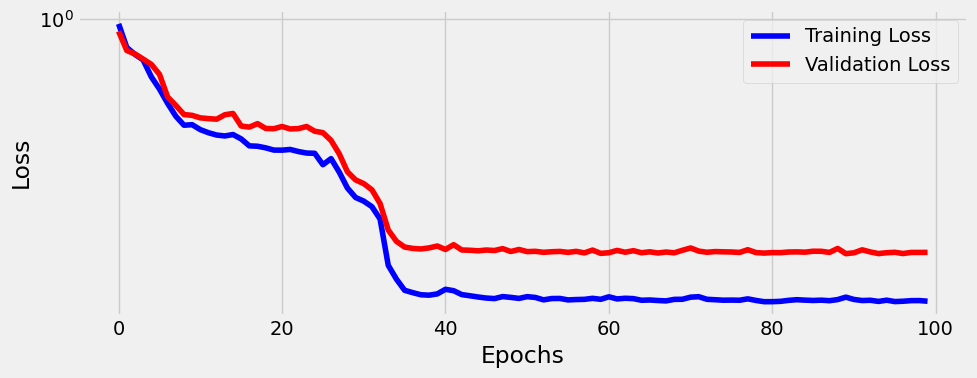

In [ ]:
fig = sbs_seq_selfattn.plot_losses()

### Visualizing Predictions

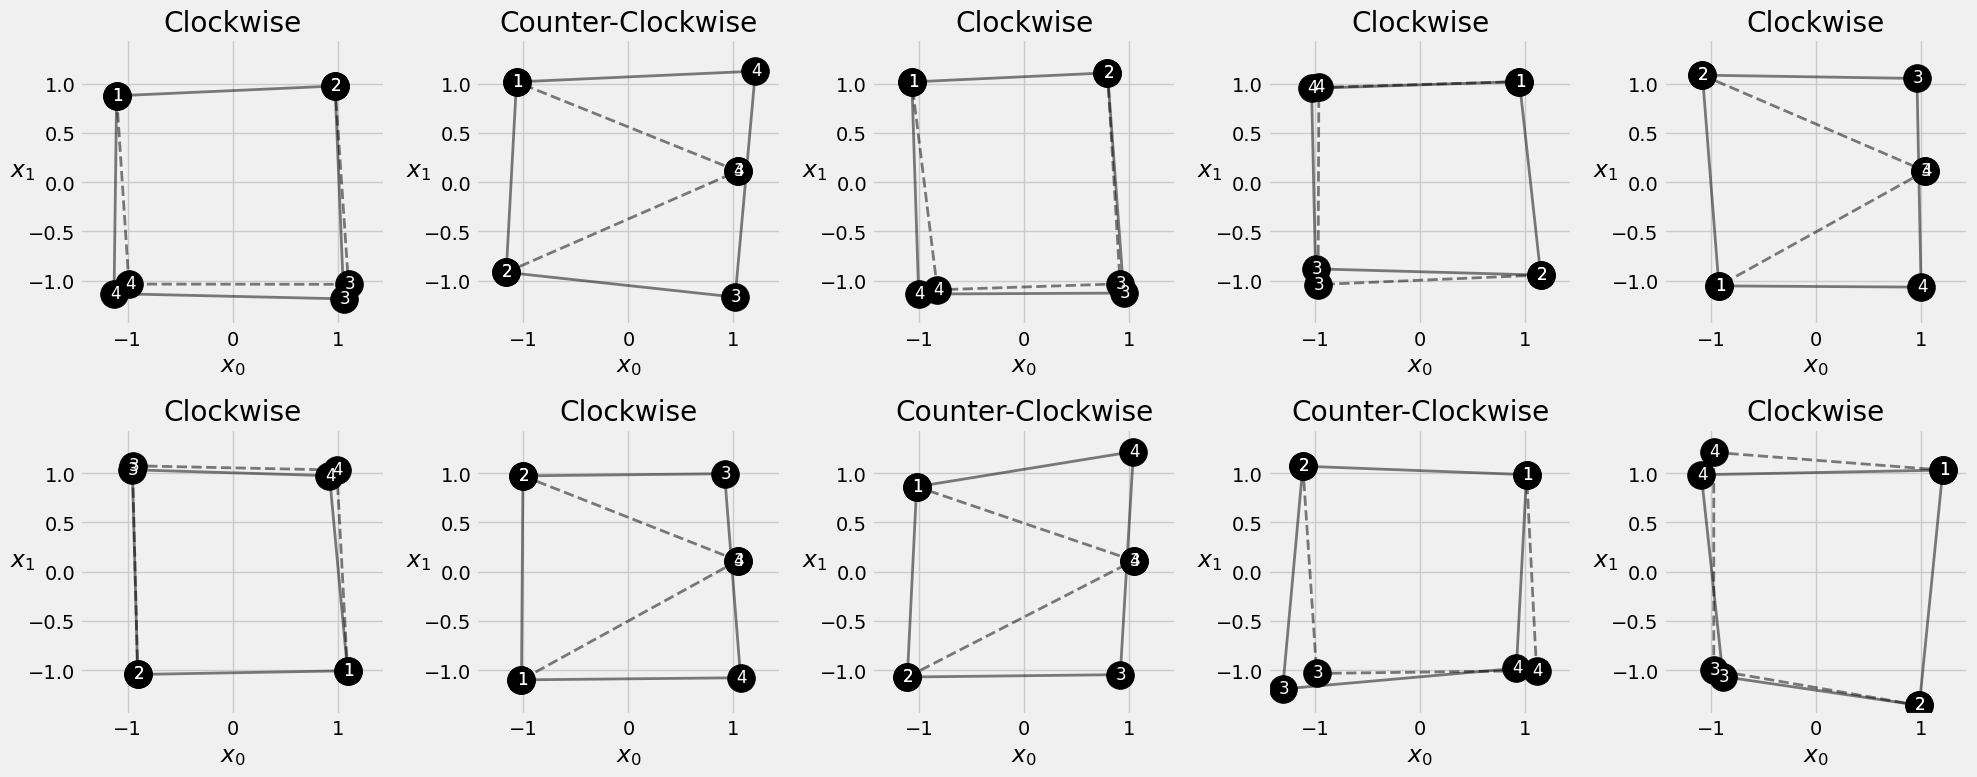

In [ ]:
fig = sequence_pred(sbs_seq_selfattn, full_test, test_directions)

Oh No!!!


The self-attention is great, but it is missing one fundamental piece of infomation... do you know which one???

We don't have the order of the points... they are handled **at once**.

Every step in the self-attention is indipendent, there is not something that is output of a step being input of the next one.

Essentially, if you flip the order of the data points in the source sequence, the encoder will ouput the "hidden states" in a different order, but it won't change their values.

### Sequential No More

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoder_lost_seq.png?raw=1)

We need to ENCODE the positional information and add it to the inputs!

## Positional Encoding (PE)

We need to inform the model about the position of every data point such that it knows the order of the data points.

**We need to generate a UNIQUE VALUE for each position in the input**

1. We could use the indices, but this is not good when dealing with long sequences with unbounded values, the values should be less than 1.


**Normalize the indices**
Divide the indices by the length of our sequence (4)

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_norm4.png?raw=1)

But for longer sequences we get values greater than 1.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_norm4_long.png?raw=1)

Normalize the sequences by its own lengths...

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_mod4mod8.png?raw=1)

unfortunately, the same position gets different encodings...
Ideally, the PE should remain constant for a given position, regardless the length of the sequences.

... Let's take the module and then normalize it.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm4.png?raw=1)

The values, now, are not unique...


Thinking out of the box, we can use not one vector, but for instance 3.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm_mult.png?raw=1)

Values are unique, other problems are solved, but... the distances between points is not preserved, this might confuse the model.

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/encoded_distances.png?raw=1)

What we can do it is to think that the encoding is moving in circle...

Therefore, we can multiply the current encoding by 360 and get angles

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm_deg.png?raw=1)

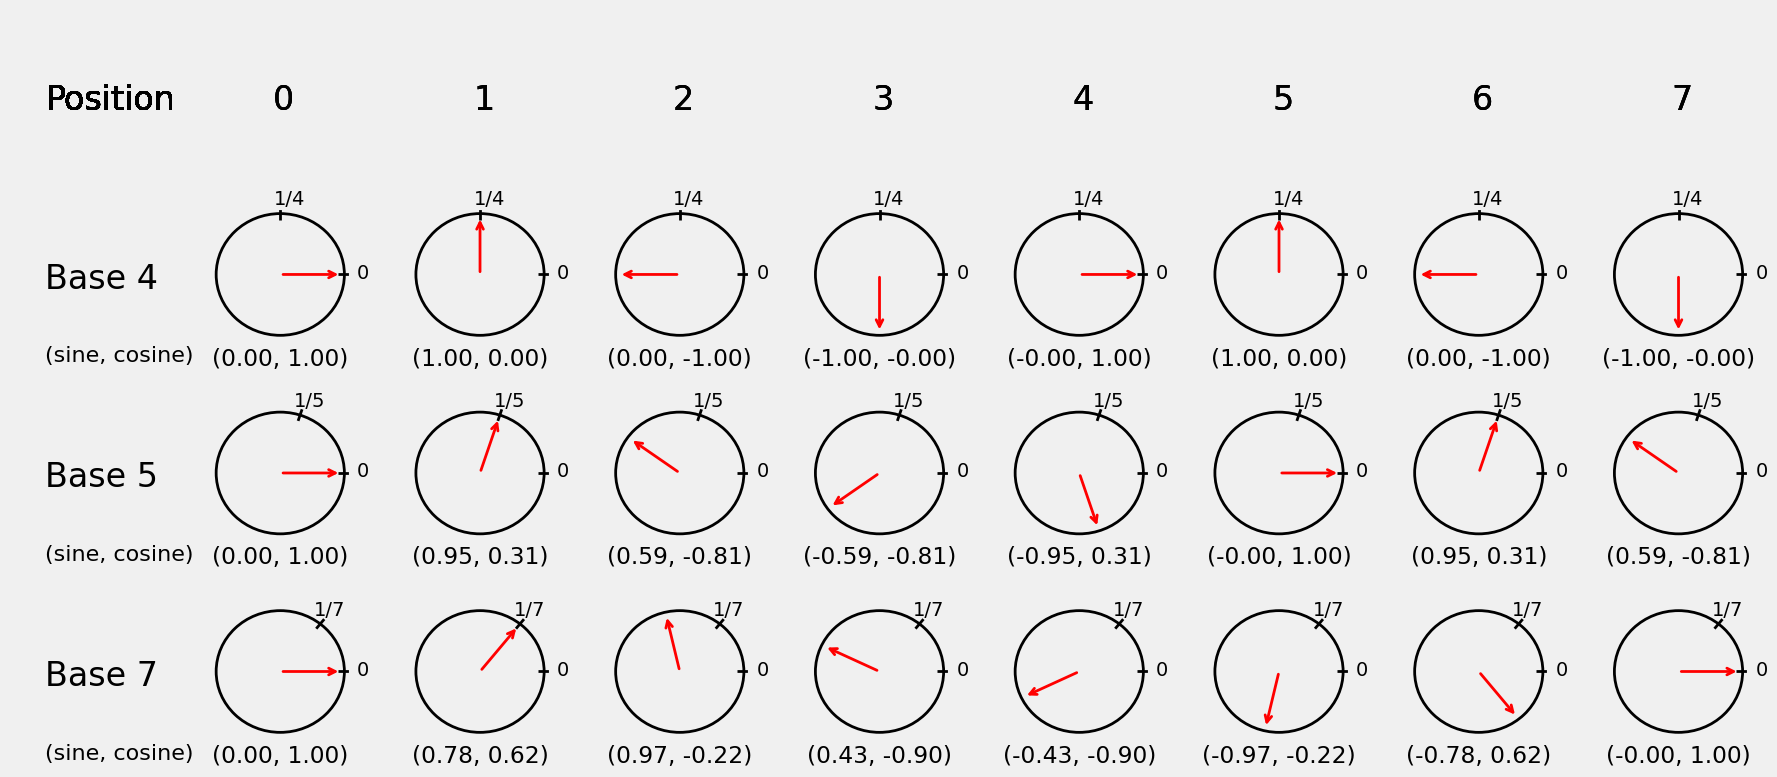

In [ ]:
fig = encoding_degrees(dims=3, seqs=(4, 5, 7), tot=8)

Then we can apply sine and cosine and use them to build the positional encoding for each position

![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/posenc_modnorm_sincos.png?raw=1)

3 vectors, generating **6 coordinates or dimensions**


![](https://github.com/dvgodoy/PyTorchStepByStep/blob/master/images/sincos_distance.png?raw=1)

To decide the "*bases*", we can do the following:

- the first vector move along the circle as many radians as the index of the position, one radian is approximately 57.3 degrees.
- For the second we move along the circle with exponentially slower angular speeds, e.g. one-tenth of a radian, 5.73 degrees
- Again for the third, one-hundredth of a radian, and so on and so forth

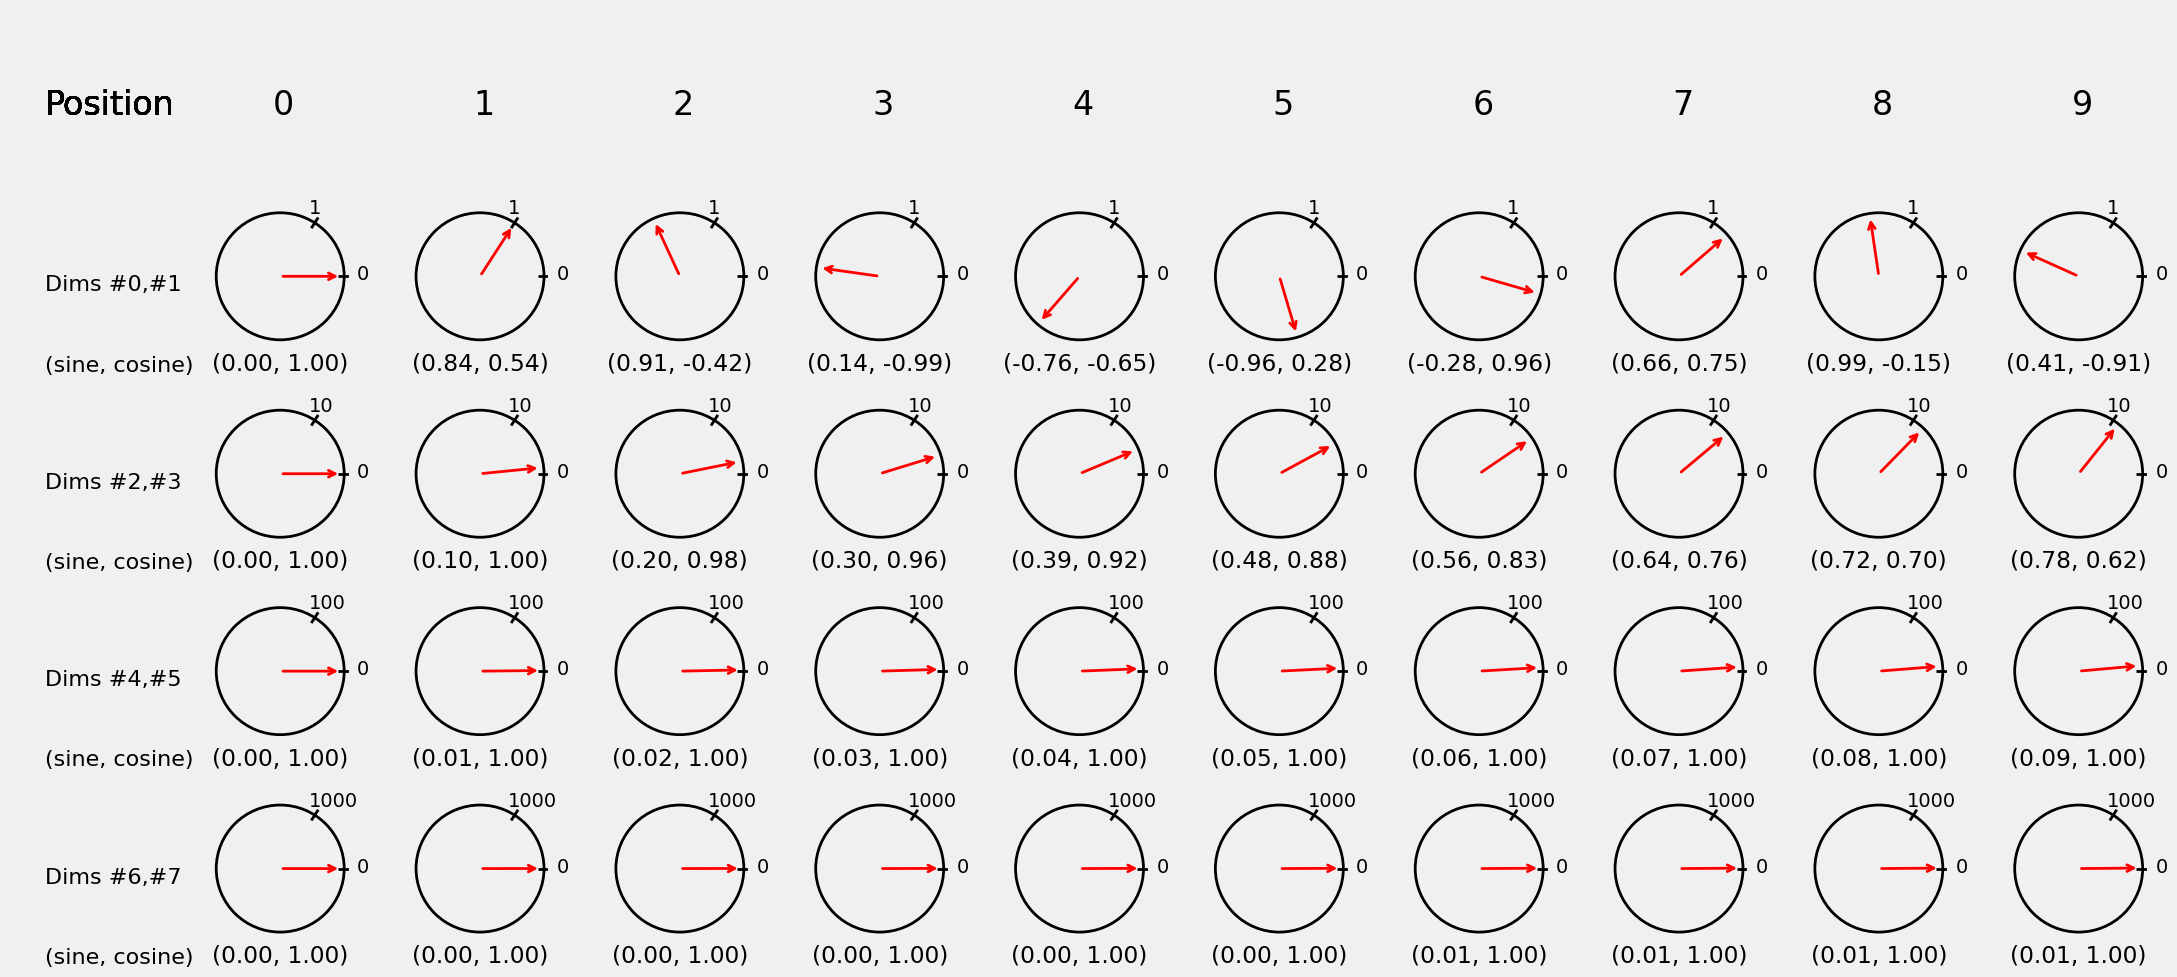

In [ ]:
fig = exponential_dials(d_model=8, max_len=10)

$$
\Large
\left(\frac{1}{10000^{\frac{0}{8}}}, \frac{1}{10000^{\frac{2}{8}}}, \frac{1}{10000^{\frac{4}{8}}}, \frac{1}{10000^{\frac{6}{8}}}\right)=(1, 0.1, 0.01, 0.001)
$$

$$
\Large
\text{PE}_{\text{pos},\ 2d} = \text{sin} \left(\frac{1}{10000^{\frac{2d}{d_{\text{model}}}}}\text{pos}\right); \text{PE}_{\text{pos},\ 2d+1} = \text{cos} \left(\frac{1}{10000^{\frac{2d}{d_{\text{model}}}}}\text{pos}\right)
$$

In [ ]:
max_len = 10
d_model = 8

position = torch.arange(0, max_len).float().unsqueeze(1)
angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

encoding = torch.zeros(max_len, d_model)
encoding[:, 0::2] = torch.sin(angular_speed * position)
encoding[:, 1::2] = torch.cos(angular_speed * position)

In [ ]:
np.round(encoding[0:4], 4) # first four positions

tensor([[ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000],
        [ 0.8415,  0.5403,  0.0998,  0.9950,  0.0100,  1.0000,  0.0010,  1.0000],
        [ 0.9093, -0.4161,  0.1987,  0.9801,  0.0200,  0.9998,  0.0020,  1.0000],
        [ 0.1411, -0.9900,  0.2955,  0.9553,  0.0300,  0.9996,  0.0030,  1.0000]])

Each line represents the encoding values for each of its eight dimensions.
The first one will always have alternated zeros and ones

### A Note on Encoded Distances

In [ ]:
distances = np.zeros((5, 5))
for i, v1 in enumerate(encoding[:5]):
    for j, v2 in enumerate(encoding[:5]):
        distances[i, j] = np.linalg.norm(v1 - v2)

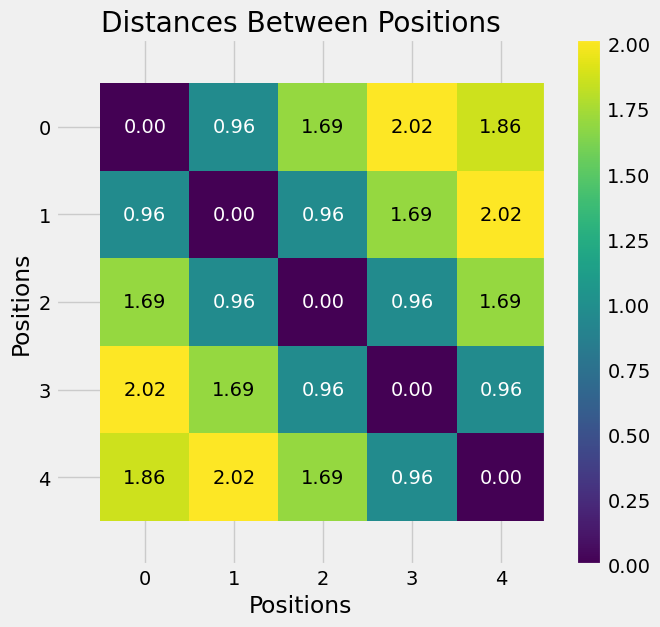

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6.5))
ax.set_title('Distances Between Positions')
fig = plot_mesh(distances, ax, showvals=True, colorbar=True, ylabel='Positions')

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # even dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

1. ```register_buffer()``` is a method used in nn.Module classes to register a tensor as a buffer rather than a parameter. Buffers are tensors associated with a model but are not trainable parameters, meaning they won’t be updated by backpropagation. However, they are still saved as part of the model’s state when you save or load the model, and they will be moved with the model if you switch devices

2. The input is scaled before adding the positional encoding



In [ ]:
posenc = PositionalEncoding(2, 2)

In [ ]:
list(posenc.parameters()), posenc.state_dict()

([],
 OrderedDict([('pe', tensor([[[0.0000, 1.0000],
                        [0.8415, 0.5403]]]))]))

In [ ]:
posenc.pe

tensor([[[0.0000, 1.0000],
         [0.8415, 0.5403]]])

In [ ]:
source_seq # 1, L, D

tensor([[[-1., -1.],
         [-1.,  1.]]])

In [ ]:
source_seq + posenc.pe

tensor([[[-1.0000,  0.0000],
         [-0.1585,  1.5403]]])

$$
\Large
\text{standardized}\ x = \frac{\text{"raw"}\ x}{\sqrt{d_x}} \implies \text{"raw"} x = \sqrt{d_x}\ \text{standardized}\ x
$$

In [ ]:
posenc(source_seq)

tensor([[[-1.4142, -0.4142],
         [-0.5727,  1.9545]]])

### Encoder + Decoder + PE

In [ ]:
class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model, ff_units, n_features)

    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out

class DecoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = DecoderSelfAttn(n_heads, d_model, ff_units, n_features)

    def init_keys(self, states):
        self.layer.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, source_mask, target_mask)
        return out

### Model Configuration & Training

In [ ]:
torch.manual_seed(43)
encpe = EncoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)
decpe = DecoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)

model = EncoderDecoderSelfAttn(encpe, decpe, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
sbs_seq_selfattnpe = StepByStep(model, loss, optimizer)
sbs_seq_selfattnpe.set_loaders(train_loader, test_loader)
sbs_seq_selfattnpe.train(100)

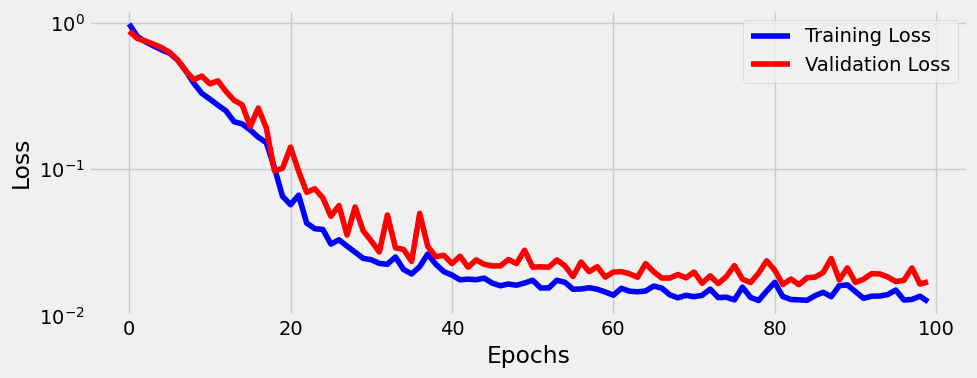

In [ ]:
fig = sbs_seq_selfattnpe.plot_losses()

### Visualizing Predictions

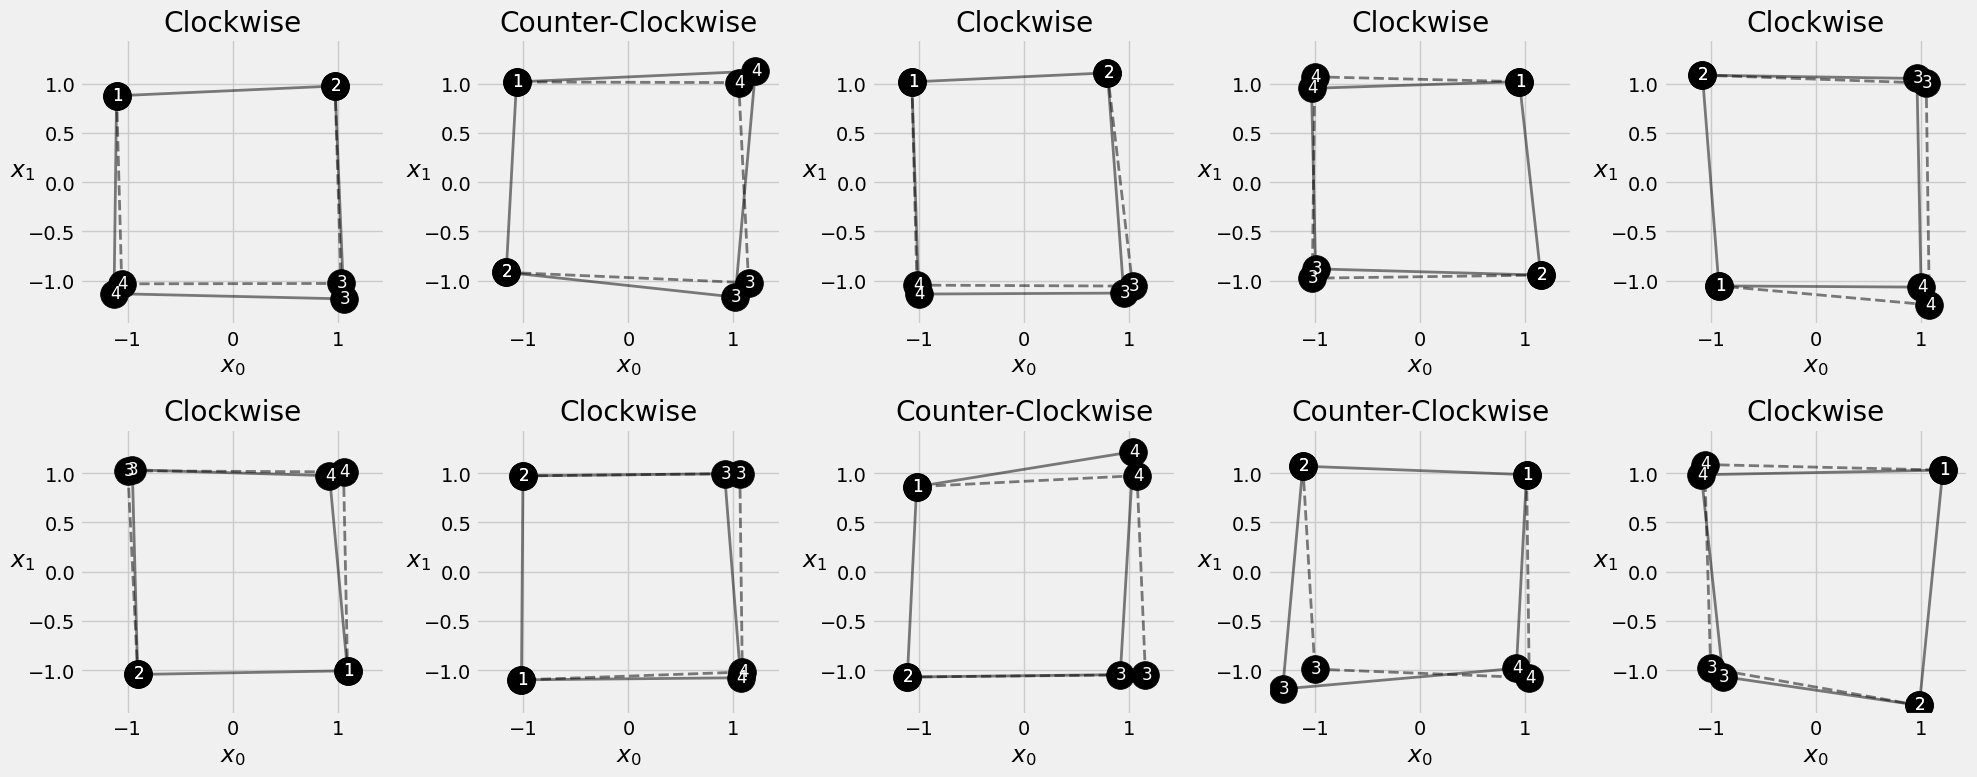

In [ ]:
fig = sequence_pred(sbs_seq_selfattnpe, full_test, test_directions)

### Visualizing Attention

We have now 3 heads and three attention mechanisms to visualize


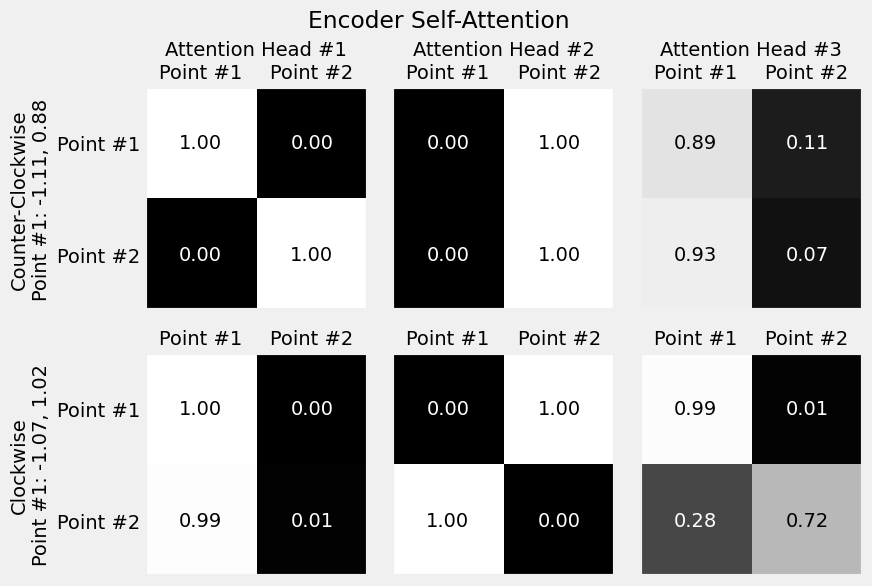

In [ ]:
inputs = full_test[:2, :2]
source_labels = ['Point #1', 'Point #2']
target_labels = ['Point #3', 'Point #4']
point_labels = [f'{"Counter-" if not directions[i] else ""}Clockwise\nPoint #1: {inp[0, 0]:.2f}, {inp[0, 1]:.2f}' for i, inp in enumerate(inputs)]

fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, decoder=False, self_attn=True, alphas_attr='encoder.layer.self_attn_heads.alphas')
fig.suptitle('Encoder Self-Attention')
fig.subplots_adjust(top=0.85)

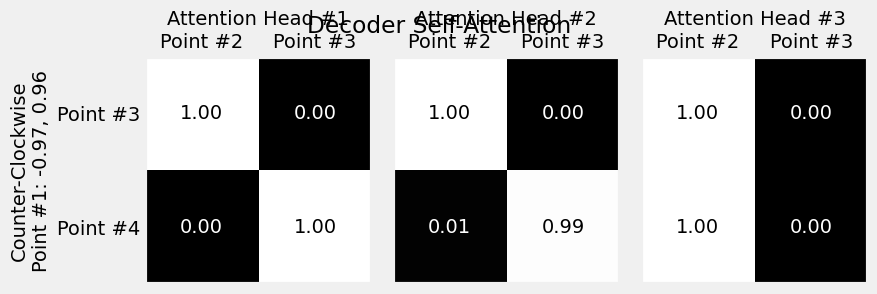

In [ ]:
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels,
                     decoder=True, self_attn=True, alphas_attr='decoder.layer.self_attn_heads.alphas')
fig.suptitle('Decoder Self-Attention')
fig.subplots_adjust(top=0.85)

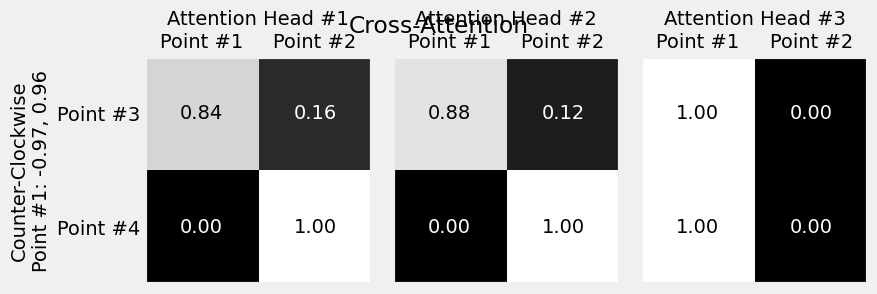

In [ ]:
fig = plot_attention(model, inputs, point_labels, source_labels, target_labels, self_attn=False, alphas_attr='decoder.layer.cross_attn_heads.alphas')
fig.suptitle('Cross-Attention')
fig.subplots_adjust(top=0.85)

## Putting It All Together

### Data Preparation

In [ ]:
# Training set
points, directions = generate_sequences(n=256, seed=13)
full_train = torch.as_tensor(points).float()
target_train = full_train[:, 2:]
train_data = TensorDataset(full_train, target_train)

generator = torch.Generator()
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, generator=generator)

# Validation/Test Set
test_points, test_directions = generate_sequences(seed=19)
full_test = torch.as_tensor(test_points).float()
source_test = full_test[:, :2]
target_test = full_test[:, 2:]
test_data = TensorDataset(source_test, target_test)
test_loader = DataLoader(test_data, batch_size=16)

### Model Assembly

In [ ]:
class EncoderDecoderSelfAttn(nn.Module):
    def __init__(self, encoder, decoder, input_len, target_len):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.input_len = input_len
        self.target_len = target_len
        self.trg_masks = self.subsequent_mask(self.target_len)

    @staticmethod
    def subsequent_mask(size):
        attn_shape = (1, size, size)
        subsequent_mask = (1 - torch.triu(torch.ones(attn_shape), diagonal=1))
        return subsequent_mask

    def encode(self, source_seq, source_mask):
        # Encodes the source sequence and uses the result
        # to initialize the decoder
        encoder_states = self.encoder(source_seq, source_mask)
        self.decoder.init_keys(encoder_states)

    def decode(self, shifted_target_seq, source_mask=None, target_mask=None):
        # Decodes/generates a sequence using the shifted (masked)
        # target sequence - used in TRAIN mode
        outputs = self.decoder(shifted_target_seq,
                               source_mask=source_mask,
                               target_mask=target_mask)
        return outputs

    def predict(self, source_seq, source_mask):
        # Decodes/generates a sequence using one input
        # at a time - used in EVAL mode
        inputs = source_seq[:, -1:]
        for i in range(self.target_len):
            out = self.decode(inputs, source_mask, self.trg_masks[:, :i+1, :i+1])
            out = torch.cat([inputs, out[:, -1:, :]], dim=-2)
            inputs = out.detach()
        outputs = inputs[:, 1:, :]
        return outputs

    def forward(self, X, source_mask=None):
        # Sends the mask to the same device as the inputs
        self.trg_masks = self.trg_masks.type_as(X).bool()
        # Slices the input to get source sequence
        source_seq = X[:, :self.input_len, :]
        # Encodes source sequence AND initializes decoder
        self.encode(source_seq, source_mask)
        if self.training:
            # Slices the input to get the shifted target seq
            shifted_target_seq = X[:, self.input_len-1:-1, :]
            # Decodes using the mask to prevent cheating
            outputs = self.decode(shifted_target_seq, source_mask, self.trg_masks)
        else:
            # Decodes using its own predictions
            outputs = self.predict(source_seq, source_mask)

        return outputs

### Encoder + Decoder + Positional Encoding

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).float().unsqueeze(1)
        angular_speed = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * angular_speed) # even dimensions
        pe[:, 1::2] = torch.cos(position * angular_speed) # odd dimensions
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # x is N, L, D
        # pe is 1, maxlen, D
        scaled_x = x * np.sqrt(self.d_model)
        encoded = scaled_x + self.pe[:, :x.size(1), :]
        return encoded

class EncoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = EncoderSelfAttn(n_heads, d_model, ff_units, n_features)

    def forward(self, query, mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, mask)
        return out

class DecoderPe(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None, max_len=100):
        super().__init__()
        pe_dim = d_model if n_features is None else n_features
        self.pe = PositionalEncoding(max_len, pe_dim)
        self.layer = DecoderSelfAttn(n_heads, d_model, ff_units, n_features)

    def init_keys(self, states):
        self.layer.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        query_pe = self.pe(query)
        out = self.layer(query_pe, source_mask, target_mask)
        return out

### Self-Attention "Layers"

In [ ]:
class EncoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=n_features)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, d_model),
        )

    def forward(self, query, mask=None):
        self.self_attn_heads.init_keys(query)
        att = self.self_attn_heads(query, mask)
        out = self.ffn(att)
        return out

class DecoderSelfAttn(nn.Module):
    def __init__(self, n_heads, d_model, ff_units, n_features=None):
        super().__init__()
        self.n_heads = n_heads
        self.d_model = d_model
        self.ff_units = ff_units
        self.n_features = d_model if n_features is None else n_features
        self.self_attn_heads = MultiHeadAttention(n_heads, d_model, input_dim=self.n_features)
        self.cross_attn_heads = MultiHeadAttention(n_heads, d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_units),
            nn.ReLU(),
            nn.Linear(ff_units, self.n_features),
        )

    def init_keys(self, states):
        self.cross_attn_heads.init_keys(states)

    def forward(self, query, source_mask=None, target_mask=None):
        self.self_attn_heads.init_keys(query)
        att1 = self.self_attn_heads(query, target_mask)
        att2 = self.cross_attn_heads(att1, source_mask)
        out = self.ffn(att2)
        return out

### Attention Heads

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_heads, d_model, input_dim=None, proj_values=True):
        super().__init__()
        self.linear_out = nn.Linear(n_heads * d_model, d_model)
        self.attn_heads = nn.ModuleList([Attention(d_model,
                                                   input_dim=input_dim,
                                                   proj_values=proj_values)
                                         for _ in range(n_heads)])

    def init_keys(self, key):
        for attn in self.attn_heads:
            attn.init_keys(key)

    @property
    def alphas(self):
        # Shape: n_heads, N, 1, L (source)
        return torch.stack([attn.alphas for attn in self.attn_heads], dim=0)

    def output_function(self, contexts):
        # N, 1, n_heads * D
        concatenated = torch.cat(contexts, axis=-1)
        out = self.linear_out(concatenated) # N, 1, D
        return out

    def forward(self, query, mask=None):
        contexts = [attn(query, mask=mask) for attn in self.attn_heads]
        out = self.output_function(contexts)
        return out

class Attention(nn.Module):
    def __init__(self, hidden_dim, input_dim=None, proj_values=False):
        super().__init__()
        self.d_k = hidden_dim
        self.input_dim = hidden_dim if input_dim is None else input_dim
        self.proj_values = proj_values
        self.linear_query = nn.Linear(self.input_dim, hidden_dim)
        self.linear_key = nn.Linear(self.input_dim, hidden_dim)
        self.linear_value = nn.Linear(self.input_dim, hidden_dim)
        self.alphas = None

    def init_keys(self, keys):
        self.keys = keys
        self.proj_keys = self.linear_key(self.keys)
        self.values = self.linear_value(self.keys) \
                      if self.proj_values else self.keys

    def score_function(self, query):
        proj_query = self.linear_query(query)
        # scaled dot product
        # N, 1, H x N, H, L -> N, 1, L
        dot_products = torch.bmm(proj_query, self.proj_keys.permute(0, 2, 1))
        scores =  dot_products / np.sqrt(self.d_k)
        return scores

    def forward(self, query, mask=None):
        # Query is batch-first N, 1, H
        scores = self.score_function(query) # N, 1, L
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        alphas = F.softmax(scores, dim=-1) # N, 1, L
        self.alphas = alphas.detach()

        # N, 1, L x N, L, H -> N, 1, H
        context = torch.bmm(alphas, self.values)
        return context

### Model Configuration & Training

In [ ]:
torch.manual_seed(43)
encpe = EncoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)
decpe = DecoderPe(n_heads=3, d_model=2, ff_units=10, n_features=2)

model = EncoderDecoderSelfAttn(encpe, decpe, input_len=2, target_len=2)
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [ ]:
sbs_seq_selfattnpe = StepByStep(model, loss, optimizer)
sbs_seq_selfattnpe.set_loaders(train_loader, test_loader)
sbs_seq_selfattnpe.train(100)

In [ ]:
sbs_seq_selfattnpe.losses[-1], sbs_seq_selfattnpe.val_losses[-1]

(0.012407604604959488, 0.016991371638141572)